## Paper Organization Evaluation Part 

SU SYNTHETIC DATASET

Introduzione su cosa rappresentano lo score importance plot e mettre alcuni esempi di quelli applicati al dataset delle due palle o alcuni dei dataset sintetici. 

Generare/Cercare dataset sintetico per fare prove dei modelli

Mettere tabella che descrive la struttura del dataset/dei vari dataset che utilizziamo 

Mettere Bar Plot come ora ma anche Bar Plot con barre orizzontali con score di importanza delle feature scritti numerici 

Applicare GFI e comparare con un dataset reale con ground truth. 

IDEAS ON HOW TO GENERATE NEW SYNTHETIC DATASETS

1. Modify the Synthetic dataset we already have (try to search the code to generate it from the Carletti paper) making it a little more challenging. This can be done reducing the number of anomalous points along the x,y,bisec axes or adding new anomalies along other directions. For example bisector of all the axes in the feature space so that the feature importance should be equally divided among all features. We want to show the big difference there is between the datasets with anomalies along a single axis (so all the importance is on feture 0 or feature 1) and the ones where anomalies are there because we have strange values combined on multiple axes. 

2. See if I can find some synthetic datasets already done in Internet. 

## Modification of the Synthetic Datasets 

The Synthetic Datasets we already have are well explained in Section 3.1 of the DIFFI paper (pag. 8 of the PDF). Another description of it is also presented in another paper presenting DIFFI (DIFFI_2.pdf) in Section 5 - Datasets. 

The dataset is built on a set id 2D point with cartesian coordinates: 

x=pho*cos(theta)

y=pho*sen(theta)

We have 900 inliers and 50 outliers. Inliers points have theta from an Uniform(0,2pi) and rho from a Uniform(0,1). Outliers instead have theta in Uniform(0,2pi) and rho in Uniform(1,30) (in the original DIFFI paper the rho is from an Uniform(4,30)). 

Then we add d-2 additional noisy features and they are simply white noise samples (so extracted from a N(0,1)). 




Let's create the Cartesian points 

In [1]:
import sys
import numpy as np
from datetime import datetime
import pandas as pd
import argparse
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
sys.path.append('../')
from utils import *
#from utils.feature_selection import *
from plot import *
from simulation_setup import *
from models import *
from models.Extended_IF import *
from models.Extended_DIFFI import *
from models.Extended_DIFFI_original import *
import math
import seaborn as sns
sns.set()

import os
import pickle 
import scipy.io

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
import os 
os.chdir('../')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'

Dividere Inlier da Outlier e fare train solo sugli Inlier e poi test (Bar Plot) solo sugli Outlier. 

In [17]:
def generate_cartesian_points(size,n_col,contamination_factor):
    n_outliers=int(np.round(size*contamination_factor))
    n_inliers=size+n_outliers
    # Inliers
    theta_in=np.random.uniform(0,2*math.pi,size=n_inliers)
    rho_in=np.random.uniform(0,3,size=n_inliers)

    # Outliers
    theta_out=np.random.uniform(0,2*math.pi,size=n_outliers)
    rho_out=np.random.uniform(4,30,size=n_outliers)

    inliers=np.column_stack((rho_in*np.cos(theta_in),rho_in*np.sin(theta_in)))
    outliers=np.column_stack((rho_out*np.cos(theta_out),rho_out*np.sin(theta_out)))

    #Ball in 6 dimensions

    theta_in=np.random.uniform(0,2*math.pi,size=(n_inliers,n_col))
    rho_in=np.random.uniform(0,3,size=(n_inliers,n_col))

    inliers=np.column_stack((inliers,noise_inliers))
    y_inlier=np.zeros(shape=inliers.shape[0])
    outliers=np.column_stack((outliers,noise_outliers))
    y_outlier=np.ones(shape=outliers.shape[0])

    #data=np.row_stack((inliers,outliers))
    #y=np.concatenate((y_inlier,y_outlier))

    return inliers,y_inlier,outliers,y_outlier


In [16]:
def generate_random_points_in_ball(size, dimensions, radius):
    if dimensions <= 0 or radius <= 0:
        raise ValueError("Dimensions and radius must be positive values.")
    
    points = []
    
    while len(points) < size:
        point = np.random.uniform(low=-radius, high=radius, size=dimensions)
        if np.linalg.norm(point) <= radius:
            points.append(point)
            
    return points

In [17]:
# Example usage
size = 1000
dimensions = 6
radius = 5.0

X_train = np.array(generate_random_points_in_ball(size, dimensions, radius))

In [32]:
d={
    'X_train':X_train
}
file_to_read = os.getcwd()+'\\ball_6_dim.pkl'
with open(file_to_read, 'wb') as file:
    pickle.dump(d,file)

In [33]:
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\utils'

Cartesian Coordinates + Noisy Features 

The dataset generated in this way it's like the X_train we load from syn_train.pkl 

In [18]:
X_train_mine,y_train_mine,X_test_mine,y_test_mine=generate_cartesian_points(900,4,0.055)
X_train_mine.shape,y_train_mine.shape

((950, 6), (950,))

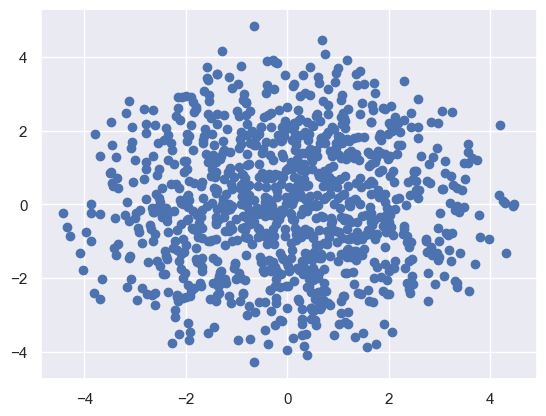

In [4]:
sns.set()
plt.scatter(X_train[:,0],X_train[:,1])
plt.show()

In [56]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data'

In [7]:
d={
    'X_train': X_train_mine,
    'y_train': y_train_mine,
    'X_test': X_test_mine,
    'y_test': y_test_mine,
}

file_to_read = os.getcwd()+'\\syn_train_100.pkl'
with open(file_to_read, 'wb') as file:
    pickle.dump(d,file)

In [57]:
file_to_read = open(os.getcwd()+'\\syn_train_100.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train,y_train= loaded_dictionary['X_train'],loaded_dictionary['y_train']

In [18]:
X_train.shape,y_train.shape

((950, 6), (950,))

We have to create the anomalies and save them in a test dataset like X_xaxis. In this case they had 1000 point in X_train and 100 in X_xaxis -> so they used 10% of anomalies. 

In [29]:
file_to_read = open(os.getcwd()+'\\syn_test.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_xaxis,X_yaxis,X_bisec = loaded_dictionary['X_xaxis'],loaded_dictionary['X_yaxis'],loaded_dictionary['X_bisec']

### Pairplots to check if I did it right 

Pairplot where we compare 100 points extracted from X_train to X_xaxis 

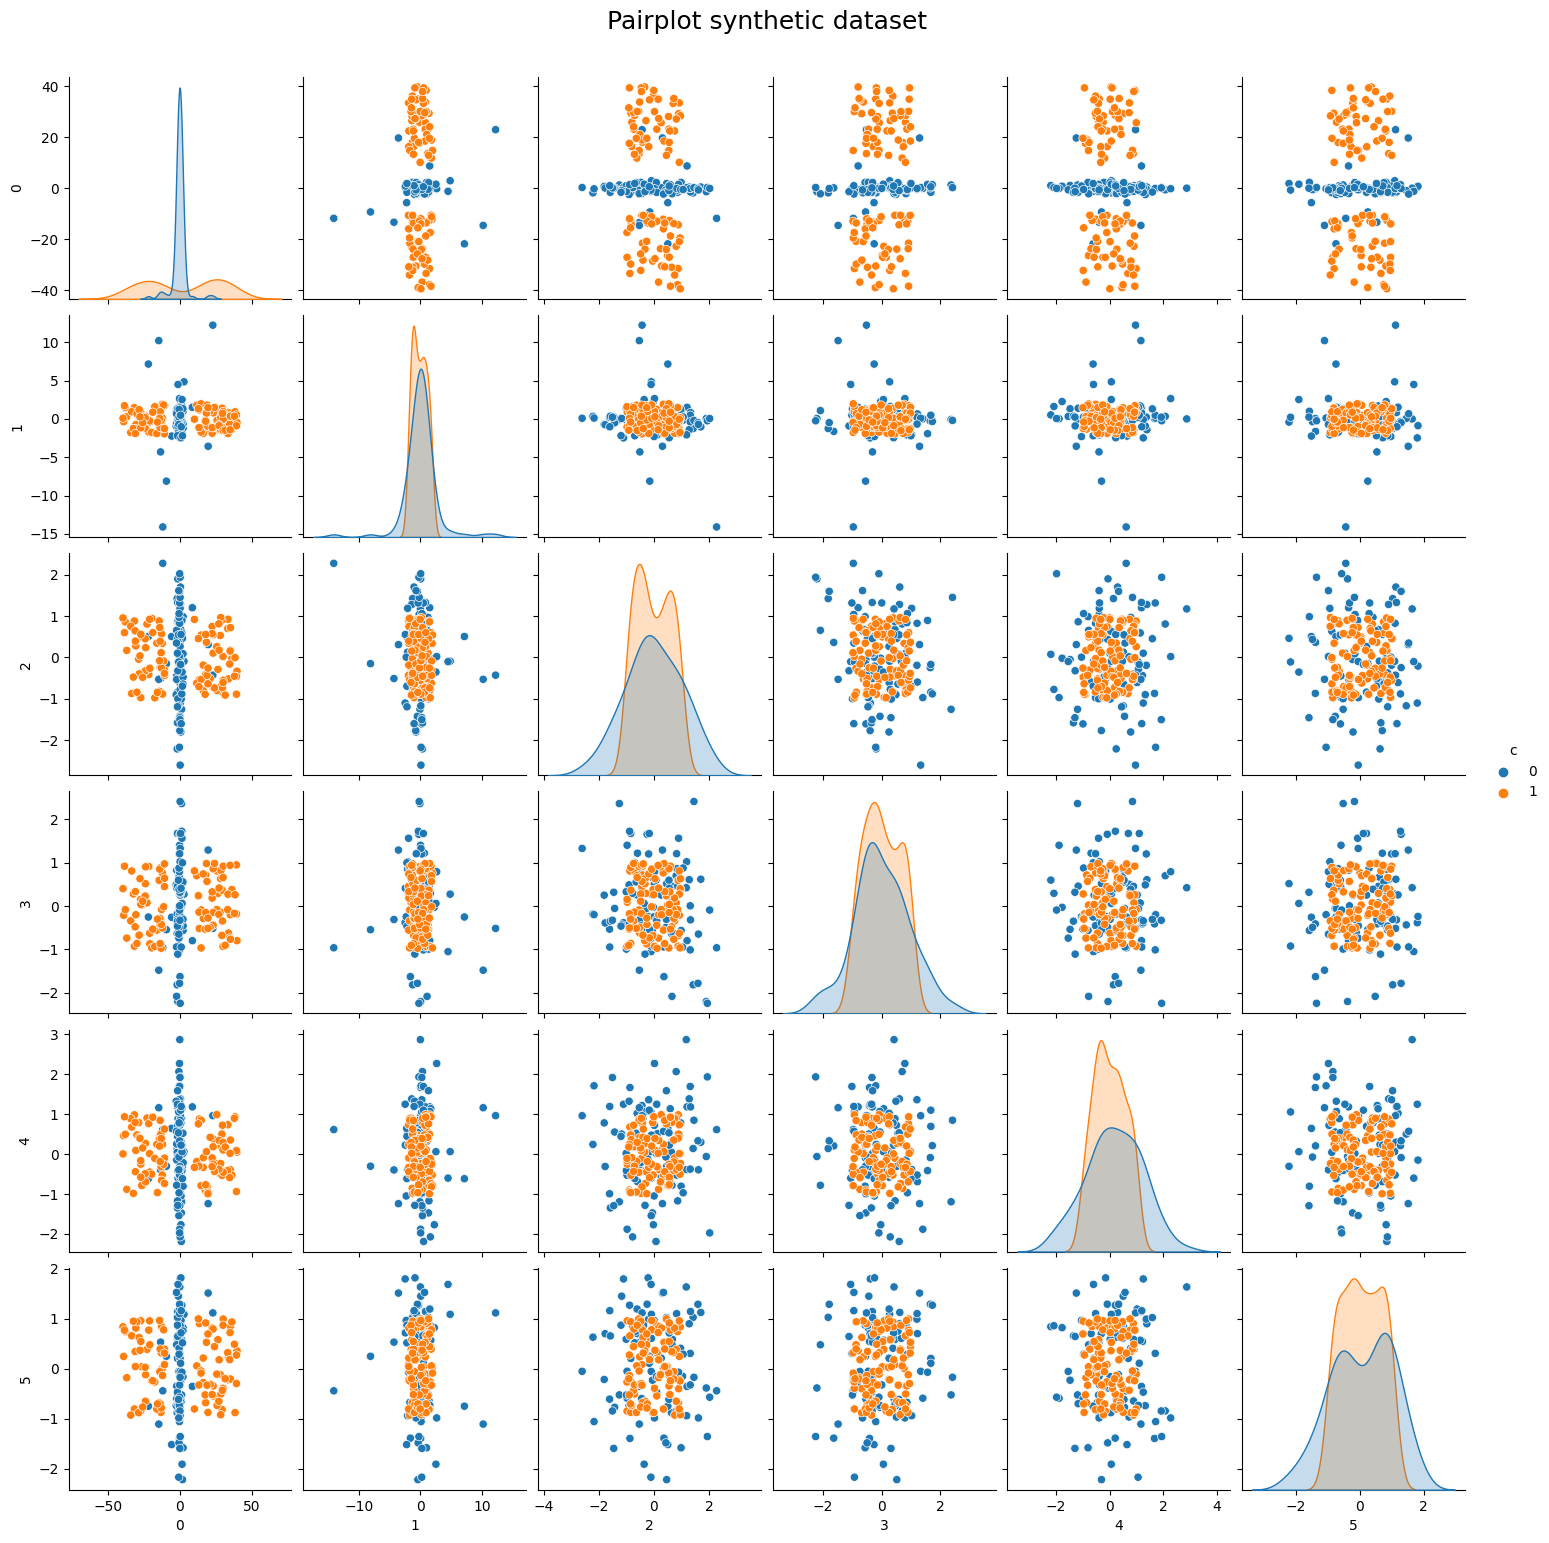

In [9]:
a = pd.DataFrame(X_train);a['c'] = 0
b = pd.DataFrame(X_xaxis);b['c'] = 1
df = pd.concat([a.sample(100),b],axis=0,ignore_index=True)
pairplot = sns.pairplot(data=df,hue='c')
pairplot.fig.suptitle("Pairplot synthetic dataset",y=1.03,fontsize=18)
plt.show()

#### X_xaxis

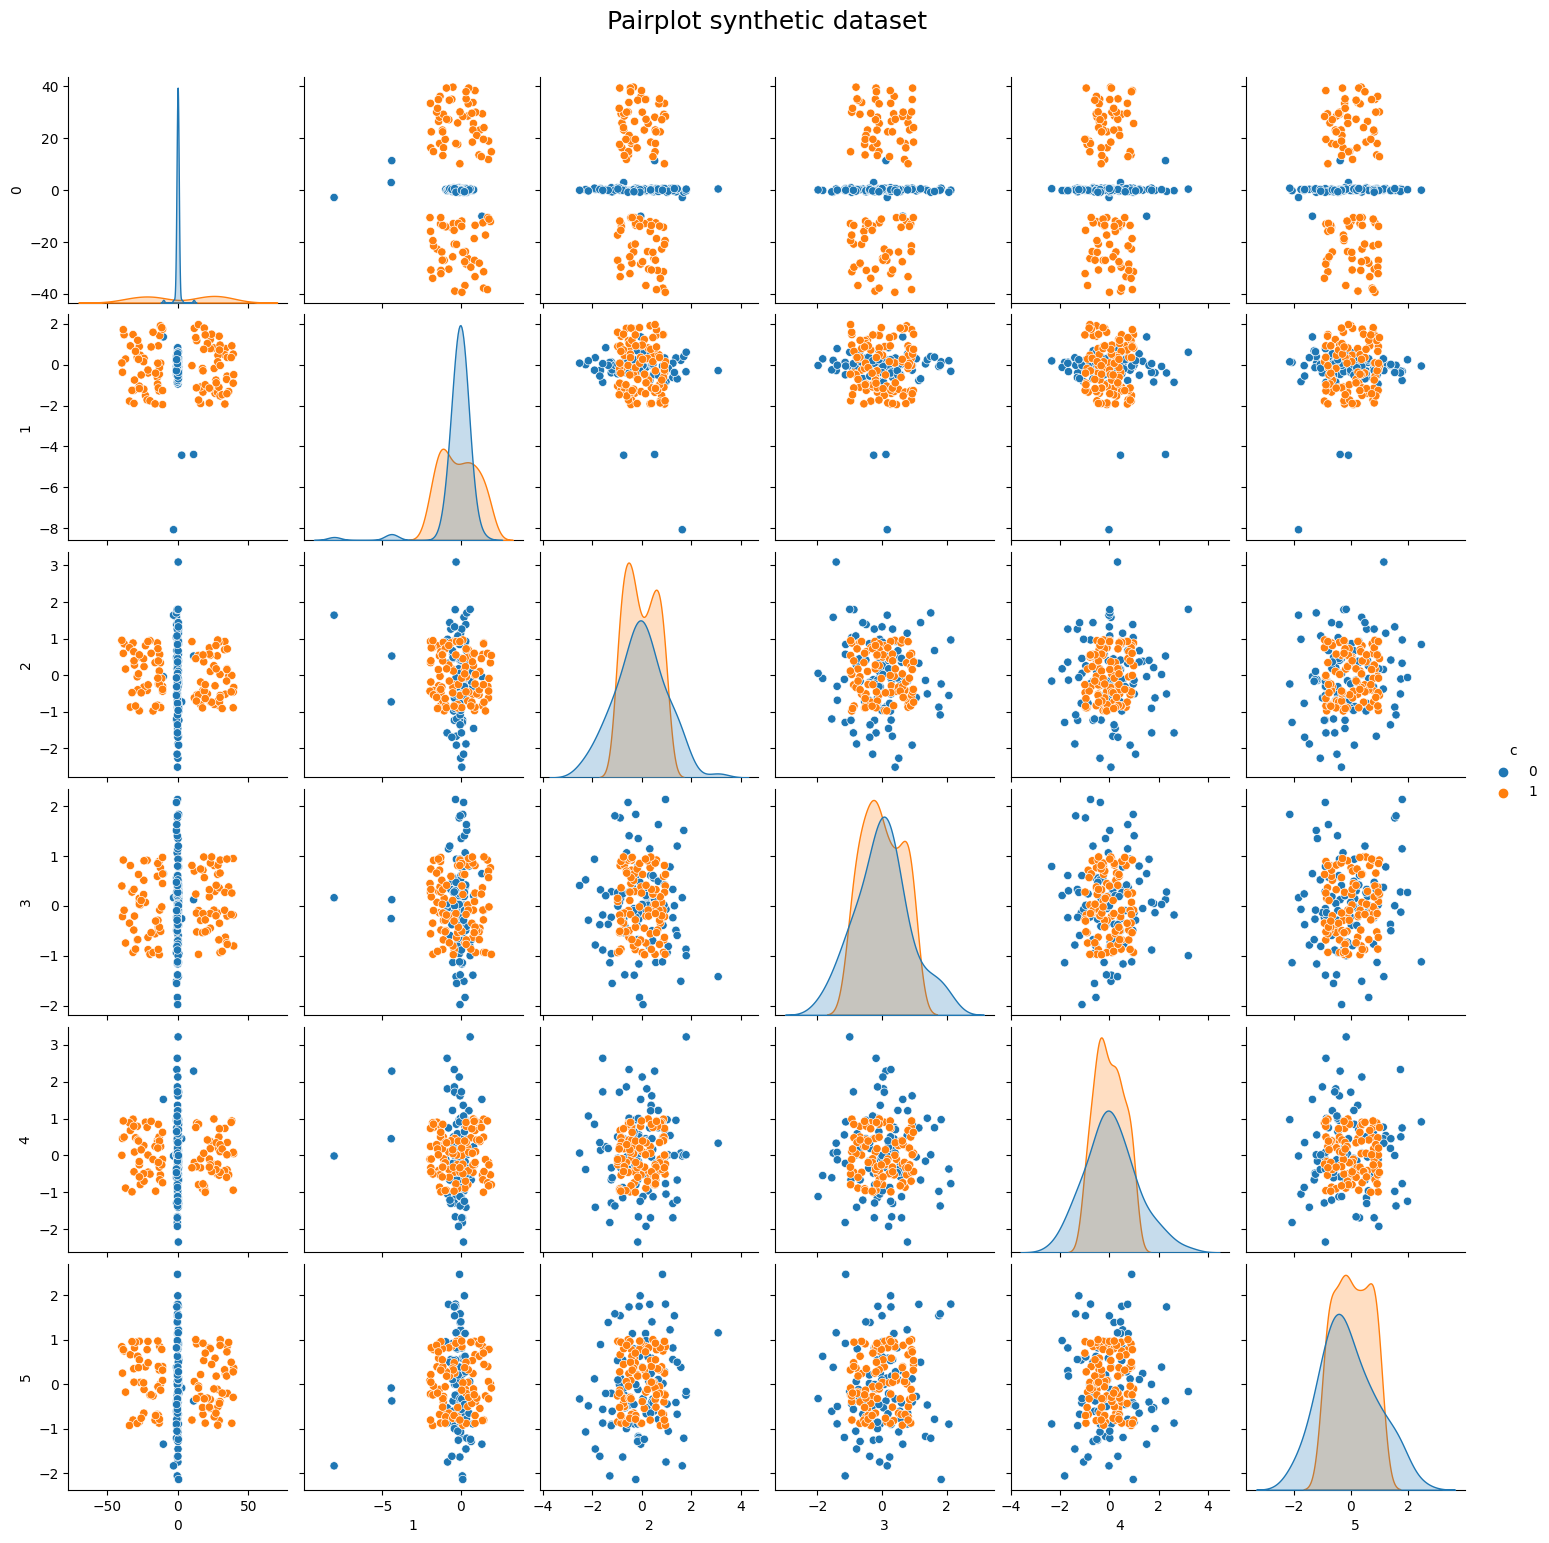

In [12]:
a = pd.DataFrame(X_train_mine);a['c'] = 0
b = pd.DataFrame(X_xaxis);b['c'] = 1
df = pd.concat([a.sample(100),b],axis=0,ignore_index=True)
pairplot = sns.pairplot(data=df,hue='c')
pairplot.fig.suptitle("Pairplot synthetic dataset",y=1.03,fontsize=18)
plt.show()

As it is possible to see from the first row and the first column of the pairplot the anomalies (the blue points) are aligned along the feature 0 axis. 

#### X_yaxis

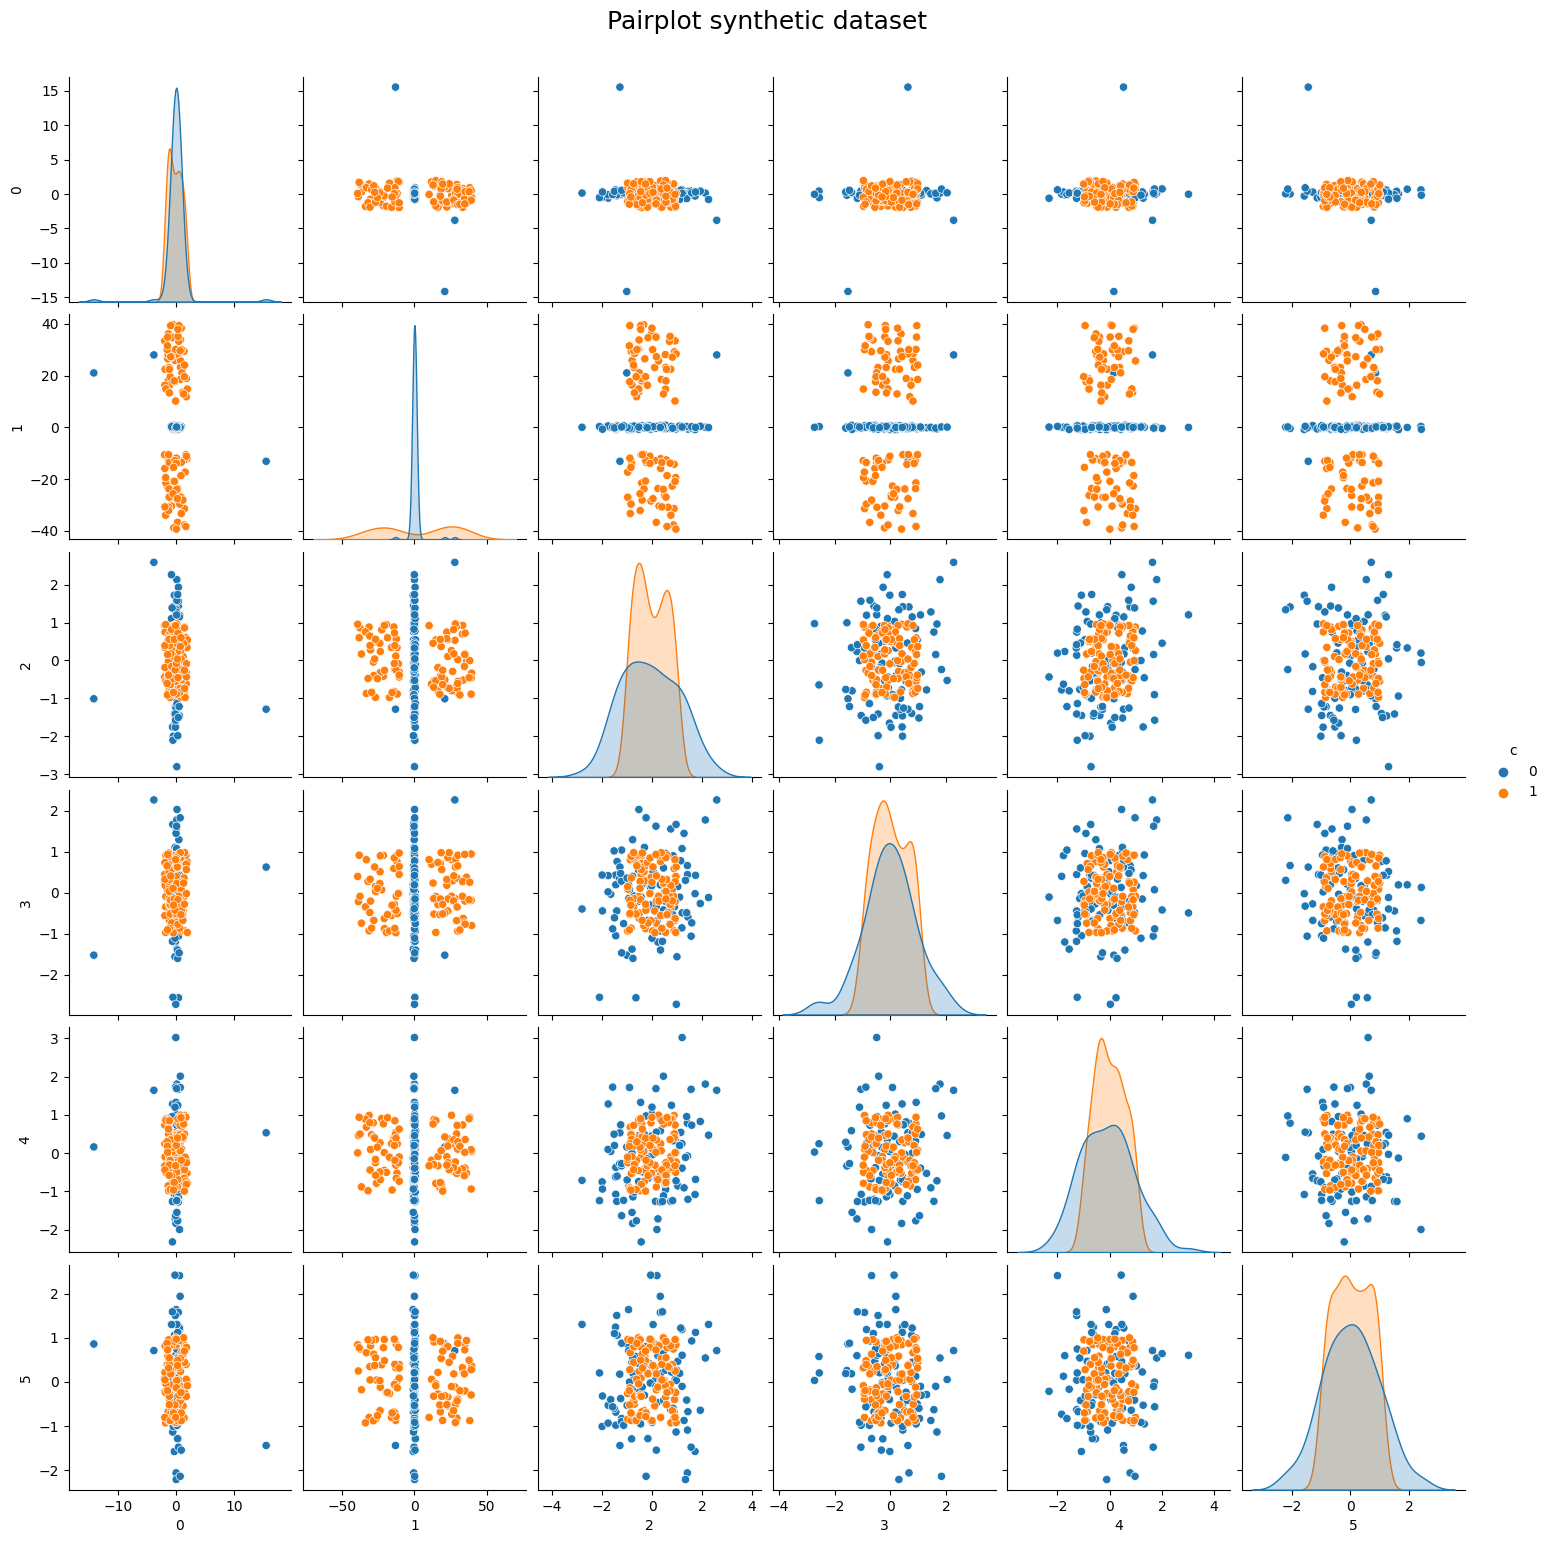

In [13]:
a = pd.DataFrame(X_train_mine);a['c'] = 0
b = pd.DataFrame(X_yaxis);b['c'] = 1
df = pd.concat([a.sample(100),b],axis=0,ignore_index=True)
pairplot = sns.pairplot(data=df,hue='c')
pairplot.fig.suptitle("Pairplot synthetic dataset",y=1.03,fontsize=18)
plt.show()

Here the situation is the same as the one in the previous pairplot but since the anomalous feature is feature 1 now the difference can be seen in the second row and second column. 

#### X_bisec

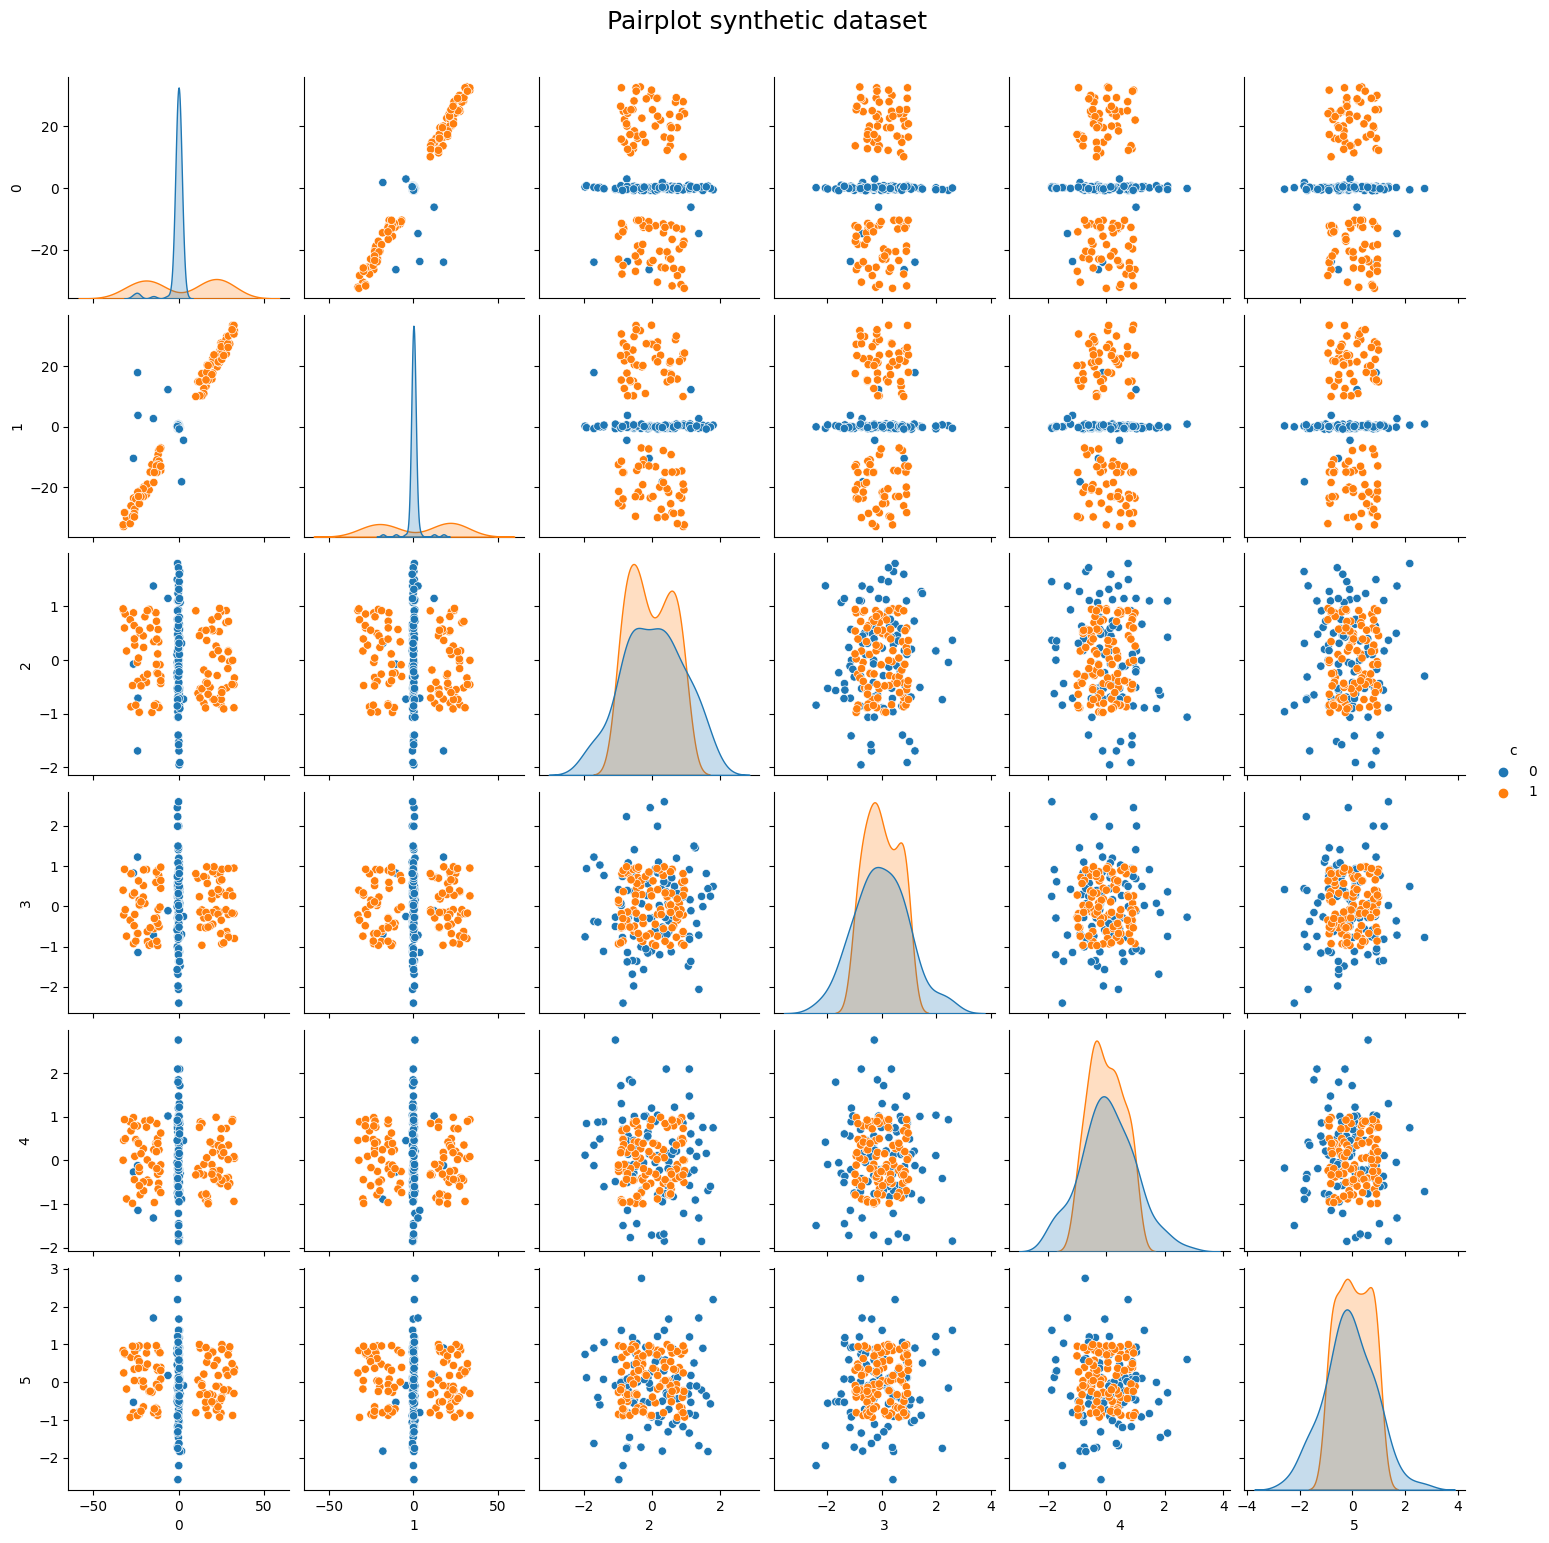

In [14]:
a = pd.DataFrame(X_train_mine);a['c'] = 0
b = pd.DataFrame(X_bisec);b['c'] = 1
df = pd.concat([a.sample(100),b],axis=0,ignore_index=True)
pairplot = sns.pairplot(data=df,hue='c')
pairplot.fig.suptitle("Pairplot synthetic dataset",y=1.03,fontsize=18)
plt.show()

Finally in this case the the anomalous points are distributed along the bisector of the 2-dimensional hyperplane between feature 0 and feature 1 (e.g along the line with equation feature0=feature1). This effect can be clearly seen in the two subplots representing the relationship between feature 0 and feture 1 so the ones in position [0,1] and [1,0] of the pairplot. 

## Test Set Generation 

To generate the random points along a line, for example along y=2x, I can generate the points on the x axis randomly (with np.random.uniform) and then obtain the corresponding y value simply multiplying the x value obtained by 2 -> maybe I can add a little random noise on the computation of y to avoid having the generation of a perfect line. 

After having generated the (x,y) points in this way I just need to simply attach the 4 noisy white noise variables to them. 

## X_xaxis tigthened 

We want to restrict the anomalies to be placed not more between [10,40] and [-40,-10] but for example between [+-3,+-7]. But I have to create the xaxis, yaxis and bisector anomalies in order to do that since before they were taken from the pkl file. 

# NEW INTERVAL FOR THE ANOMALY GENERATION

In [2]:
def generate_x_axis(size,min,max):
    x=np.random.uniform(min,max,size=size)
    y=np.random.normal(0,1,size=(x.shape[0],5))
    xy=np.column_stack((x,y))
    return xy

## METTERE 7,12 INVECE CHE ANOMALY INTERVAL[0] E [1]

In [20]:
xy1=generate_x_axis(50,anomaly_interval[0],anomaly_interval[1])
xy2=generate_x_axis(50,-anomaly_interval[1],-anomaly_interval[0])
X_xaxis=np.row_stack((xy1,xy2))
X_xaxis.shape

(100, 6)

## X_yaxis tightened 

In [3]:
def generate_y_axis(size,min,max):
    x=np.random.normal(0,1,size=size)
    y=np.random.uniform(min,max,size=x.shape[0])
    xy=np.column_stack((x,y))
    z=np.random.normal(0,1,size=(x.shape[0],4))
    xyz=np.column_stack((xy,z))
    return xyz

In [22]:
xy1=generate_y_axis(50,anomaly_interval[0],anomaly_interval[1])
xy2=generate_y_axis(50,-anomaly_interval[1],-anomaly_interval[0])
X_yaxis=np.row_stack((xy1,xy2))
X_yaxis.shape

(100, 6)

## X_bisec tightened

In [4]:
def bisect(size,min,max,d,dim=6):
    data=np.zeros(shape=(size,dim))
    data[:,0]=np.random.uniform(min,max,size=size)
    for i in range(1,d):
        data[:,i]=data[:,0]+np.random.normal(0,1,size=size)

    for i in range(d,dim):
        data[:,i]=np.random.normal(0,1,size=size)

    return data

In [10]:
X_bisect=np.row_stack((bisect(50,5,10,2),bisect(50,-10,-5,2)))
X_bisect_3d=np.row_stack((bisect(50,5,10,3),bisect(50,-10,-5,3)))
X_bisect_4d=np.row_stack((bisect(50,5,10,4),bisect(50,-10,-5,4)))
X_bisect_6d=np.row_stack((bisect(50,5,10,6),bisect(50,-10,-5,6)))

In [5]:
def generate_bisect(size,min,max):
    x=np.random.uniform(min,max,size=size)
    y=(x+np.random.uniform(-1,1,size=size))
    xy=np.column_stack((x,y))
    noise=np.random.normal(0,1,size=(xy.shape[0],4))
    X_bisec=np.column_stack((xy,noise))
    return X_bisec

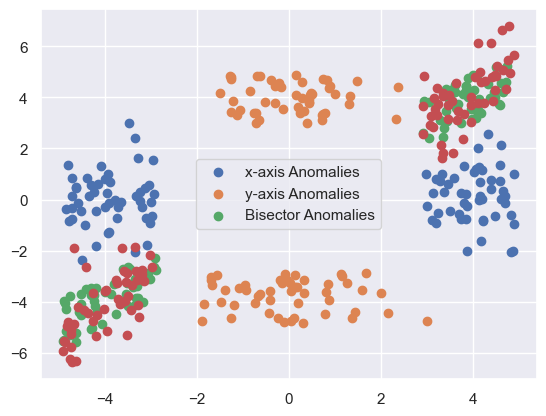

In [27]:
X_bisect=np.row_stack((generate_bisect(50,anomaly_interval[0],anomaly_interval[1]),generate_bisect(50,-anomaly_interval[1],-anomaly_interval[0])))
X_bisect_1=np.row_stack((bisect(50,anomaly_interval[0],anomaly_interval[1],2),bisect(50,-anomaly_interval[1],-anomaly_interval[0],2)))
plt.scatter(X_xaxis[:,0],X_xaxis[:,1])
plt.scatter(X_yaxis[:,0],X_yaxis[:,1])
plt.scatter(X_bisect[:,0],X_bisect[:,1])
plt.scatter(X_bisect_1[:,0],X_bisect_1[:,1])
plt.legend(['x-axis Anomalies','y-axis Anomalies',
            'Bisector Anomalies'])
plt.show()

# GENERATE ANOMALIES WITH THE NEW ANOMALY INTERVAL 

In [14]:
anomaly_interval=[7,12]
anomaly_interval_2=[np.sqrt(49/2),np.sqrt(144/2)]
anomaly_interval_3=[np.sqrt(49/3),np.sqrt(144/3)]
anomaly_interval_6=[np.sqrt(49/6),np.sqrt(144/6)]

PROVA 2

In [20]:
anomaly_interval=[5,10]
anomaly_interval_2=[np.sqrt(25/2),np.sqrt(100/2)]
anomaly_interval_3=[np.sqrt(25/3),np.sqrt(100/3)]
anomaly_interval_6=[np.sqrt(25/6),np.sqrt(100/6)]

Xaxis -> MODIFICA 

In [21]:
xy1=generate_x_axis(50,anomaly_interval[0],anomaly_interval[1])
xy2=generate_x_axis(50,-anomaly_interval[1],-anomaly_interval[0])
X_xaxis=np.row_stack((xy1,xy2))
X_xaxis.shape

(100, 6)

Yaxis

In [22]:
xy1=generate_y_axis(50,anomaly_interval[0],anomaly_interval[1])
xy2=generate_y_axis(50,-anomaly_interval[1],-anomaly_interval[0])
X_yaxis=np.row_stack((xy1,xy2))
X_yaxis.shape

(100, 6)

In [23]:
X_bisect=np.row_stack((bisect(50,anomaly_interval_2[0],anomaly_interval_2[1],2),bisect(50,-anomaly_interval_2[1],-anomaly_interval_2[0],2)))
X_bisect_3d=np.row_stack((bisect(50,anomaly_interval_3[0],anomaly_interval_3[1],3),bisect(50,-anomaly_interval_3[1],-anomaly_interval_3[0],3)))
X_bisect_6d=np.row_stack((bisect(50,anomaly_interval_6[0],anomaly_interval_6[1],6),bisect(50,-anomaly_interval_6[1],-anomaly_interval_6[0],6)))

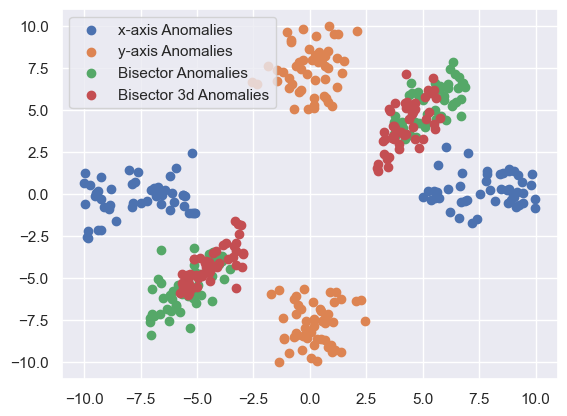

In [24]:
sns.set()
#plt.scatter(inliers[:,0],inliers[:,1])
plt.scatter(X_xaxis[:,0],X_xaxis[:,1])
plt.scatter(X_yaxis[:,0],X_yaxis[:,1])
plt.scatter(X_bisect[:,0],X_bisect[:,1])
plt.scatter(X_bisect_3d[:,0],X_bisect_3d[:,1])
#plt.scatter(xy[:,0],xy[:,1])
plt.legend(['x-axis Anomalies','y-axis Anomalies',
            'Bisector Anomalies','Bisector 3d Anomalies'])
plt.show()

In [25]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data'

In [11]:
d={
    'X_xaxis': X_xaxis,
    'X_yaxis': X_yaxis,
    'X_bisect': X_bisect,
    'X_bisect_3d': X_bisect_3d,
    'X_bisect_6d': X_bisect_6d
}

file_to_read = os.getcwd()+'\\syn_test_anomaly_interval_5_10.pkl'
with open(file_to_read, 'wb') as file:
    pickle.dump(d,file)

In [13]:
d={
    'X_bisect_3d': X_bisect_3d,
    'X_bisect_6d': X_bisect_6d,
}

file_to_read = os.getcwd()+'\\syn_test_tight_multi_dim_anomaly_interval.pkl'
with open(file_to_read, 'wb') as file:
    pickle.dump(d,file)

## X_bisec 3d,4d,6d

In [66]:
X_bisec_3d=np.row_stack((bisect(50,5,10,3),bisect(50,-10,-5,3)))
X_bisec_4d=np.row_stack((bisect(50,5,10,4),bisect(50,-10,-5,4)))
X_bisec_6d=np.row_stack((bisect(50,5,10,6),bisect(50,-10,-5,6)))
X_bisec_3d.shape,X_bisec_4d.shape,X_bisec_6d.shape

((100, 3), (100, 4), (100, 6))

In [67]:
X_bisec_3d=np.column_stack((X_bisec_3d,np.random.normal(0,1,size=(X_bisec_3d.shape[0],3))))
X_bisec_4d=np.column_stack((X_bisec_4d,np.random.normal(0,1,size=(X_bisec_4d.shape[0],2))))
X_bisec_3d.shape,X_bisec_4d.shape

((100, 6), (100, 6))

In [68]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')

In [15]:
d={
    'X_bisect_3d': X_bisect_3d,
    'X_bisect_4d': X_bisect_4d,
    'X_bisect_6d': X_bisect_6d,
}

file_to_read = os.getcwd()+'\\syn_test_tight_multi_dim_5_10.pkl'
with open(file_to_read, 'wb') as file:
    pickle.dump(d,file)

## Anti Bisector 

Let's generate the test points on the anti bisector (so bisector of second and fourth quadrant -> y=-x)

In [8]:
def generate_anti_bisector(size,min,max):
    x=np.random.uniform(min,max,size=size)
    y=-x + np.random.uniform(-3,3,size=x.shape[0])
    xy=np.column_stack((x,y))
    return xy

100 Anomalies

In [10]:
xy=generate_anti_bisector(50,np.min(X_train_mine),-10)
xy1=generate_anti_bisector(50,10,np.max(X_train_mine))
X_anti_bisect=np.row_stack((xy,xy1))

50 Anomalies

In [20]:
xy=generate_anti_bisector(25,np.min(X_train_mine),-10)
xy1=generate_anti_bisector(25,10,np.max(X_train_mine))
X_anti_bisect=np.row_stack((xy,xy1))

Now I have to add the 4 noisy features to X_anti_bisect 

In [11]:
noise=np.random.normal(0,1,size=(X_anti_bisect.shape[0],4))
X_anti_bisect=np.column_stack((X_anti_bisect,noise))
X_anti_bisect.shape

(100, 6)

### Pairlplot X_anti_bisect

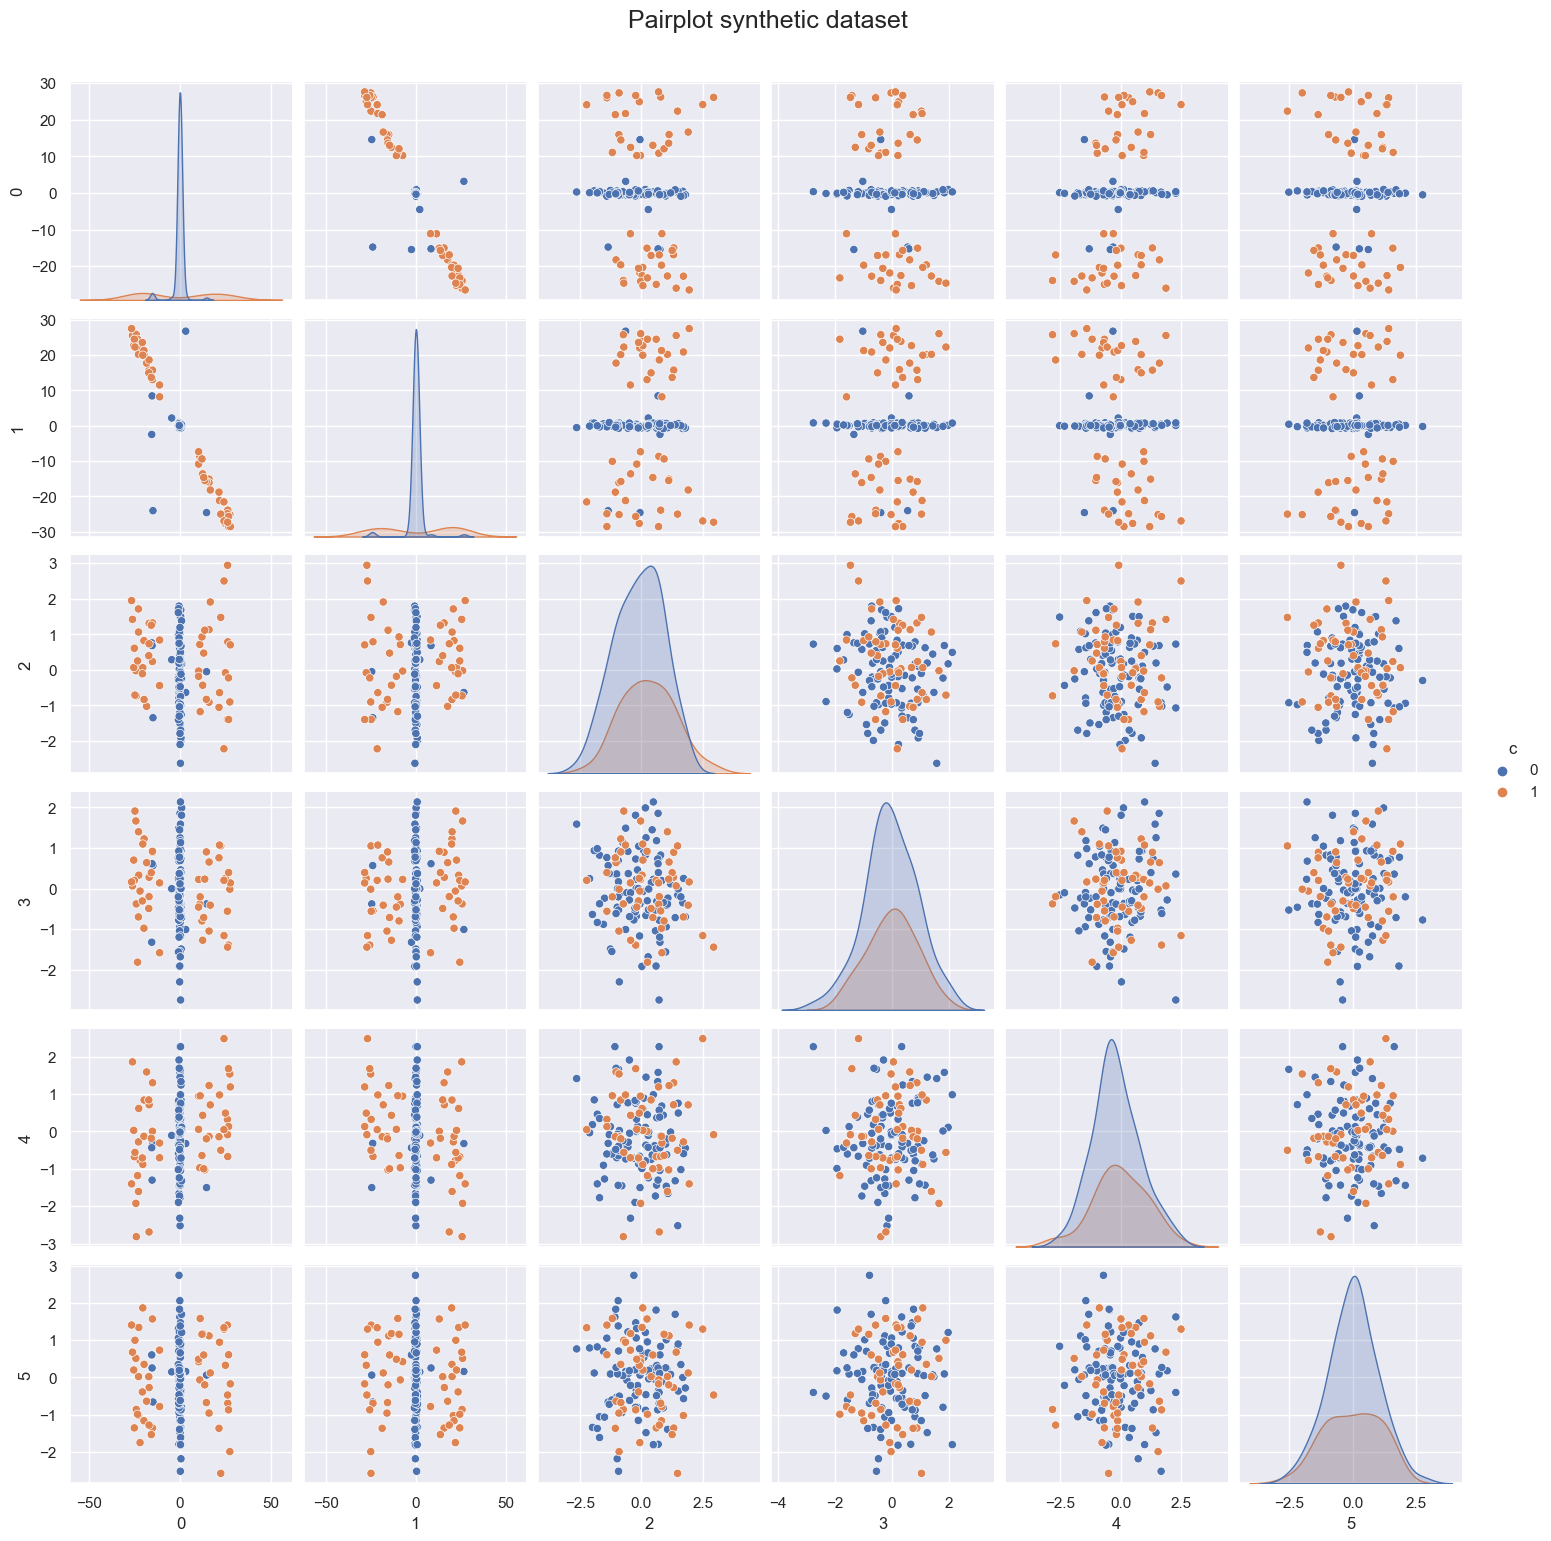

In [23]:
a = pd.DataFrame(X_train_mine);a['c'] = 0
b = pd.DataFrame(X_anti_bisect);b['c'] = 1
df = pd.concat([a.sample(100),b],axis=0,ignore_index=True)
pairplot = sns.pairplot(data=df,hue='c')
pairplot.fig.suptitle("Pairplot synthetic dataset",y=1.03,fontsize=18)
plt.show()

Now the situation is the same as for X_bisect but in positions [0,1] and [1,0] the bisector is on the opposite direction. 

## N.B. 

From what we can see from the plot of the first 2 features of X_bisec (and actually this is the same thing we can see from the plot in Figure 3 of the DIFFI paper) the anomalies do not appear in the middle part because in that part we have the big circle with the Cartesian coordinates representing the inliers. 

From the plot it seems that the middle circle is centered in the origin and has radius equal to 10. 

So this means that I have to draw from the intervals (+-10,+-40)

## Anomalies Plot 

Let's plot the first two columns (so feature 0 and feature 1) of X_xaxis,X_yaxis,X_bisec and X_anti_bisec to see how the anomalies are distributed in the feature 0 - feature 1 subspace

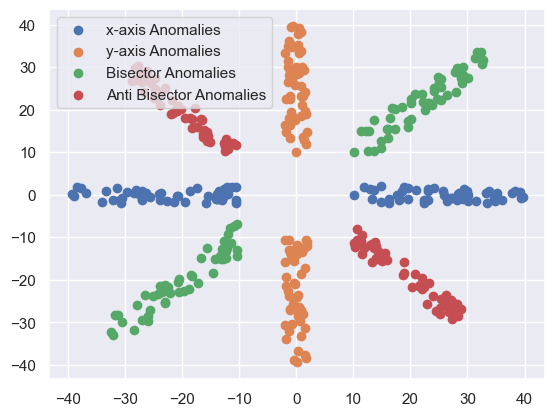

In [12]:
sns.set()
#plt.scatter(inliers[:,0],inliers[:,1])
plt.scatter(X_xaxis[:,0],X_xaxis[:,1])
plt.scatter(X_yaxis[:,0],X_yaxis[:,1])
plt.scatter(X_bisec[:,0],X_bisec[:,1])
plt.scatter(X_anti_bisect[:,0],X_anti_bisect[:,1])
#plt.scatter(xy[:,0],xy[:,1])
plt.legend(['x-axis Anomalies','y-axis Anomalies',
            'Bisector Anomalies','Anti Bisector Anomalies'])
plt.show()

50 Anomalies

In [26]:
X_xaxis_50=X_xaxis[:50,:]
X_yaxis_50=X_yaxis[:50,:]
X_bisec_50=X_bisec[:50,:]


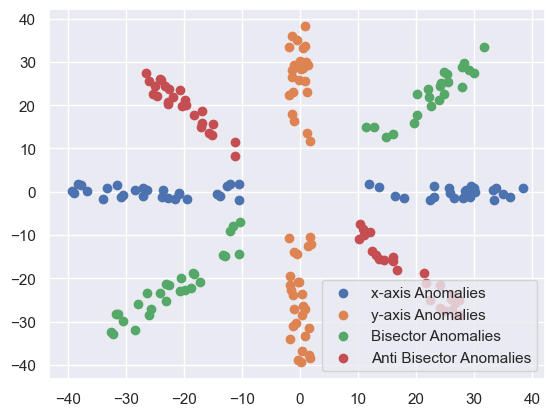

In [27]:
sns.set()
#plt.scatter(inliers[:,0],inliers[:,1])
plt.scatter(X_xaxis_50[:,0],X_xaxis_50[:50,1])
plt.scatter(X_yaxis_50[:,0],X_yaxis_50[:,1])
plt.scatter(X_bisec_50[:,0],X_bisec_50[:,1])
plt.scatter(X_anti_bisect[:,0],X_anti_bisect[:,1])
#plt.scatter(xy[:,0],xy[:,1])
plt.legend(['x-axis Anomalies','y-axis Anomalies',
            'Bisector Anomalies','Anti Bisector Anomalies'])
plt.show()

## Anomalies along a line 

We can create the anomalies along a generic line of the type y=mx+q to see what happens in this case in the feature importances. 

In [13]:
def line_anomalies(size,min,max,m,q):
    x=np.random.uniform(min,max,size=size)
    y=np.full(x.shape[0],m)*x + np.full(x.shape[0],q) + np.random.uniform(-3,3,size=x.shape[0])
    xy=np.column_stack((x,y))
    return xy

100 Anomalies

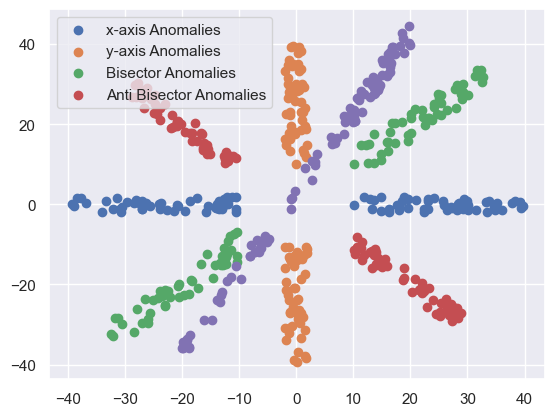

In [14]:
xy=line_anomalies(50,-20,10,2,3)
xy1=line_anomalies(50,10,20,2,3)
X_line=np.row_stack((xy,xy1))
#plt.scatter(inliers[:,0],inliers[:,1])
plt.scatter(X_xaxis[:,0],X_xaxis[:,1])
plt.scatter(X_yaxis[:,0],X_yaxis[:,1])
plt.scatter(X_bisec[:,0],X_bisec[:,1])
plt.scatter(X_anti_bisect[:,0],X_anti_bisect[:,1])
plt.scatter(X_line[:,0],X_line[:,1])
plt.legend(['x-axis Anomalies','y-axis Anomalies',
            'Bisector Anomalies','Anti Bisector Anomalies'])
plt.show()

50 Anomalies

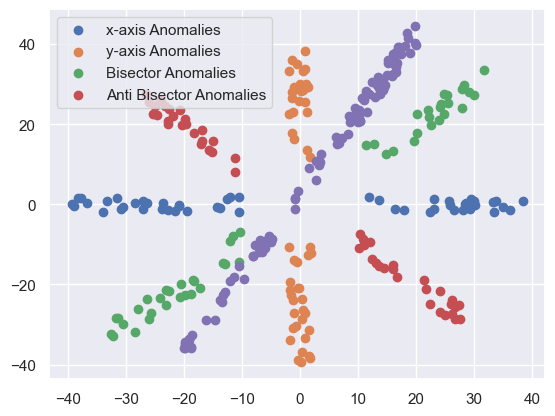

In [29]:
xy=line_anomalies(25,-20,10,2,3)
xy1=line_anomalies(25,10,20,2,3)
X_line_50=np.row_stack((xy,xy1))
#plt.scatter(inliers[:,0],inliers[:,1])
plt.scatter(X_xaxis_50[:,0],X_xaxis_50[:,1])
plt.scatter(X_yaxis_50[:,0],X_yaxis_50[:,1])
plt.scatter(X_bisec_50[:,0],X_bisec_50[:,1])
plt.scatter(X_anti_bisect[:,0],X_anti_bisect[:,1])
plt.scatter(X_line[:,0],X_line[:,1])
plt.legend(['x-axis Anomalies','y-axis Anomalies',
            'Bisector Anomalies','Anti Bisector Anomalies'])
plt.show()

Let's save this data we have created (X_train_mine,X_xaxis,X_yaxis,X_bisect,X_anti_bisect,X_line) into a pkl file so we can access them as we did with synt_train and synt_test. 


Here we are using 100 anomalies in the test set. We can also create a new version with 50 anomalies so that the situation is more challenging for the models. 

To save the data in pkl files we have to create a dictionary. 

In [15]:
X_line=np.column_stack((X_line,np.random.normal(0,1,size=(X_line.shape[0],4))))
X_line.shape

(100, 6)

In [17]:
d_train={
    'X': X_train_mine,
    'y': y_train_mine,
}

d_test={
    'X_xaxis': X_xaxis,
    'X_yaxis': X_yaxis,
    'X_bisect': X_bisec,
    'X_anti_bisect':X_anti_bisect,
    'X_line': X_line
}

In [32]:
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data'

In [33]:
file_to_read = os.getcwd()+'\\syn_train_100.pkl'
with open(file_to_read, 'wb') as file:
    pickle.dump(d_train,file)

file_to_read = os.getcwd()+'\\syn_test_100.pkl'
with open(file_to_read, 'wb') as file:
    pickle.dump(d_test,file)

In [34]:
d_test_50={
    'X_xaxis': X_xaxis,
    'X_yaxis': X_yaxis,
    'X_bisect': X_bisec,
    'X_anti_bisect':X_anti_bisect,
    'X_line': X_line
}

In [35]:
file_to_read = os.getcwd()+'\\syn_train_50.pkl'
with open(file_to_read, 'wb') as file:
    pickle.dump(d_train,file)

file_to_read = os.getcwd()+'\\syn_test_50.pkl'
with open(file_to_read, 'wb') as file:
    pickle.dump(d_test,file)

## New Type of Anomalies 

Now we want to create also some other kind of anomalies on more than 2 dimensions. For example we can create the bisector of the subplane of the first 3 fetures -> so here we expect to have the feature importance equally divided between the first 3 features. 

Then maybe we can try also with the bisector of all the 6 dimensions so that we should see the feature importance evenly divided on all the 6 features. 

### Bisector of 3 Dimensional Feature Space

The equation of the bisector in 3D is x+y+z=0 or other combinations in which we use the minus instead of the plus. 

To generate the points I will have to sample randomly the x and the y (extracting them from a uniform between a min and a max value) and then compute the z as z=-(x+y)

In [4]:
def bisect_3d(size,min,max):
    x=np.random.uniform(min,max,size=size)
    y=np.random.uniform(min,max,size=size)
    z=-(x+y) + np.random.uniform(-3,3,size=x.shape[0])
    xy=np.column_stack((x,y))
    xyz=np.column_stack((xy,z))
    return xyz

In [16]:
X_bisec_3d=np.row_stack((bisect_3d(50,10,40),bisect_3d(50,-10,-40)))
X_bisec_3d.shape

(100, 3)

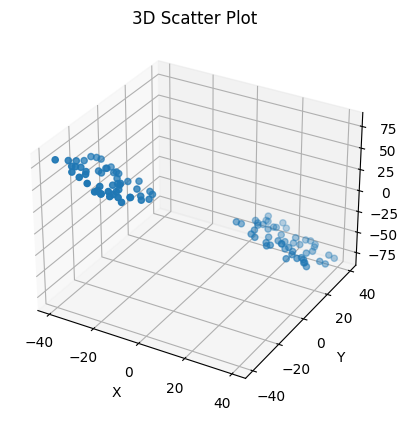

In [17]:
from mpl_toolkits.mplot3d import Axes3D
# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Create the scatter plot
ax.scatter(X_bisec_3d[:,0],X_bisec_3d[:,1],X_bisec_3d[:,2])

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot')

# Show the plot
plt.show()

It seems to be more or less the bisector

Now we just need to add 3 noisy features

In [19]:
X_bisec_3d=np.row_stack((bisect(50,10,40,3),bisect(50,-10,-40,3)))
X_bisec_3d.shape

(100, 3)

50 Anomalies

In [6]:
X_bisec_3d=np.row_stack((bisect(25,10,40,3),bisect(25,-10,-40,3)))
X_bisec_3d.shape

(50, 3)

In [7]:
noise=np.random.normal(0,1,size=(X_bisec_3d.shape[0],3))
X_bisec_3d=np.column_stack((X_bisec_3d,noise))

### Bisector of the 6 dimensional Feature Space

Now, generalizing, the bisector in 6 dimension will have equation x1+x2+x3+x4+x5+x6 so I will have to sample randomly the values of the first 5 features and then compute the 6-th feature as x6=-(x1+x2+x3+x4+x5)

In [26]:
def bisect_6d(size,min,max):
    data=np.zeros(shape=(size,6))
    for i in range(5):
        data[:,i]=np.random.uniform(min,max,size=size)
        data[:,-1]-=data[:,i]+np.random.uniform(-3,3,size=size)

    return data

In [27]:
X_bisect_6d=bisect_6d(100,10,20)
X_bisect_6d.shape

(100, 6)

I can generalize the function just created to create anomalies around of a feature space with any number of dimensions. 

Bisector in 3d 

In [15]:
X_bisect_3d=bisect(100,10,20,3)
X_bisect_3d.shape

(100, 3)

In [17]:
noise=np.random.normal(0,1,size=(X_bisec_3d.shape[0],3))
noise.shape
X_bisec_3d=np.column_stack((X_bisec_3d,noise))
X_bisec_3d.shape

(100, 6)

In [16]:
X_bisec_3d=np.row_stack((bisect(50,10,40,3),bisect(50,-10,-40,3)))
X_bisec_3d.shape

(100, 3)

Now I can create the bisector in 4 dimensions

In [7]:
X_bisect_4d=bisect(100,10,20,4)
X_bisect_4d.shape

(100, 4)

In [18]:
X_bisec_4d=np.row_stack((bisect(50,10,40,4),bisect(50,-10,-40,4)))
X_bisec_4d.shape

(100, 4)

In [19]:
noise=np.random.normal(0,1,size=(X_bisec_3d.shape[0],2))
noise.shape
X_bisec_4d=np.column_stack((X_bisec_4d,noise))
X_bisec_4d.shape

(100, 6)

Bisector in 6d

In [11]:
X_bisect_6d=bisect(100,10,20,6)
X_bisect_6d.shape

(100, 6)

50 Anomalies

In [8]:
X_bisec_4d=np.row_stack((bisect(25,10,40,4),bisect(25,-10,-40,4)))
X_bisec_4d.shape

(50, 4)

In [23]:
X_bisec_6d=np.row_stack((bisect(50,10,40,6),bisect(50,-10,-40,6)))
X_bisec_6d.shape

(100, 6)

50 Anomalies

In [10]:
X_bisec_6d=np.row_stack((bisect(25,10,40,6),bisect(25,-10,-40,6)))
X_bisec_6d.shape

(50, 6)

Let's add the 2 noisy features 

In [9]:
noise=np.random.normal(0,1,size=(X_bisec_3d.shape[0],2))
noise.shape
X_bisec_4d=np.column_stack((X_bisec_4d,noise))
X_bisec_4d.shape

(50, 6)

Let's save all these new anomalies on pkl files 

In [22]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')

In [20]:
d_test={
    'X_bisec_3d': X_bisec_3d,
    'X_bisec_4d': X_bisec_4d,
    'X_bisec_6d': X_bisec_6d
}

In [21]:
file_to_read = os.getcwd()+'\\syn_test_100_multi_dim.pkl'
with open(file_to_read, 'wb') as file:
    pickle.dump(d_test,file)

In [ ]:
file_to_read = os.getcwd()+'\\syn_test_50_multi_dim.pkl'
with open(file_to_read, 'wb') as file:
    pickle.dump(d_test,file)

Let's create the same bisectors but with 50 anomalies this time

In [15]:
X_bisec_3d=np.row_stack((bisect(25,10,40,3),bisect(25,-10,-40,3)))
X_bisec_3d=np.column_stack((X_bisec_3d,np.random.normal(0,1,size=(X_bisec_3d.shape[0],3))))
X_bisec_4d=np.row_stack((bisect(25,10,40,4),bisect(25,-10,-40,4)))
X__bisec_4d=np.column_stack((X_bisec_4d,np.random.normal(0,1,size=(X_bisec_4d.shape[0],2))))
X_bisec_6d=np.row_stack((bisect(25,10,40,6),bisect(25,-10,-40,6)))

In [16]:
X_bisec_3d.shape,X__bisec_4d.shape,X_bisec_6d.shape

((50, 6), (50, 6), (50, 6))

In [18]:
file_to_read = os.getcwd()+'\\syn_test_50_multi_dim.pkl'
with open(file_to_read, 'wb') as file:
    pickle.dump(d_test,file)

## Multi Dimensional Bisectors Pairplots 

In [7]:
file_to_read = open(os.getcwd()+'\\syn_train.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train,y_train,p = loaded_dictionary['X'],loaded_dictionary['y'],loaded_dictionary['contamination']

In [27]:
file_to_read = open(os.getcwd()+'\\syn_test_100_multi_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_bisec_3d,X_bisec_4d,X_bisec_6d = loaded_dictionary['X_bisec_3d'],loaded_dictionary['X_bisec_4d'],loaded_dictionary['X_bisec_6d']

In [33]:
file_to_read = open(os.getcwd()+'\\syn_test_100.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_anti_bisec,X_line = loaded_dictionary['X_anti_bisect'],loaded_dictionary['X_line']

### X_bisec_3d

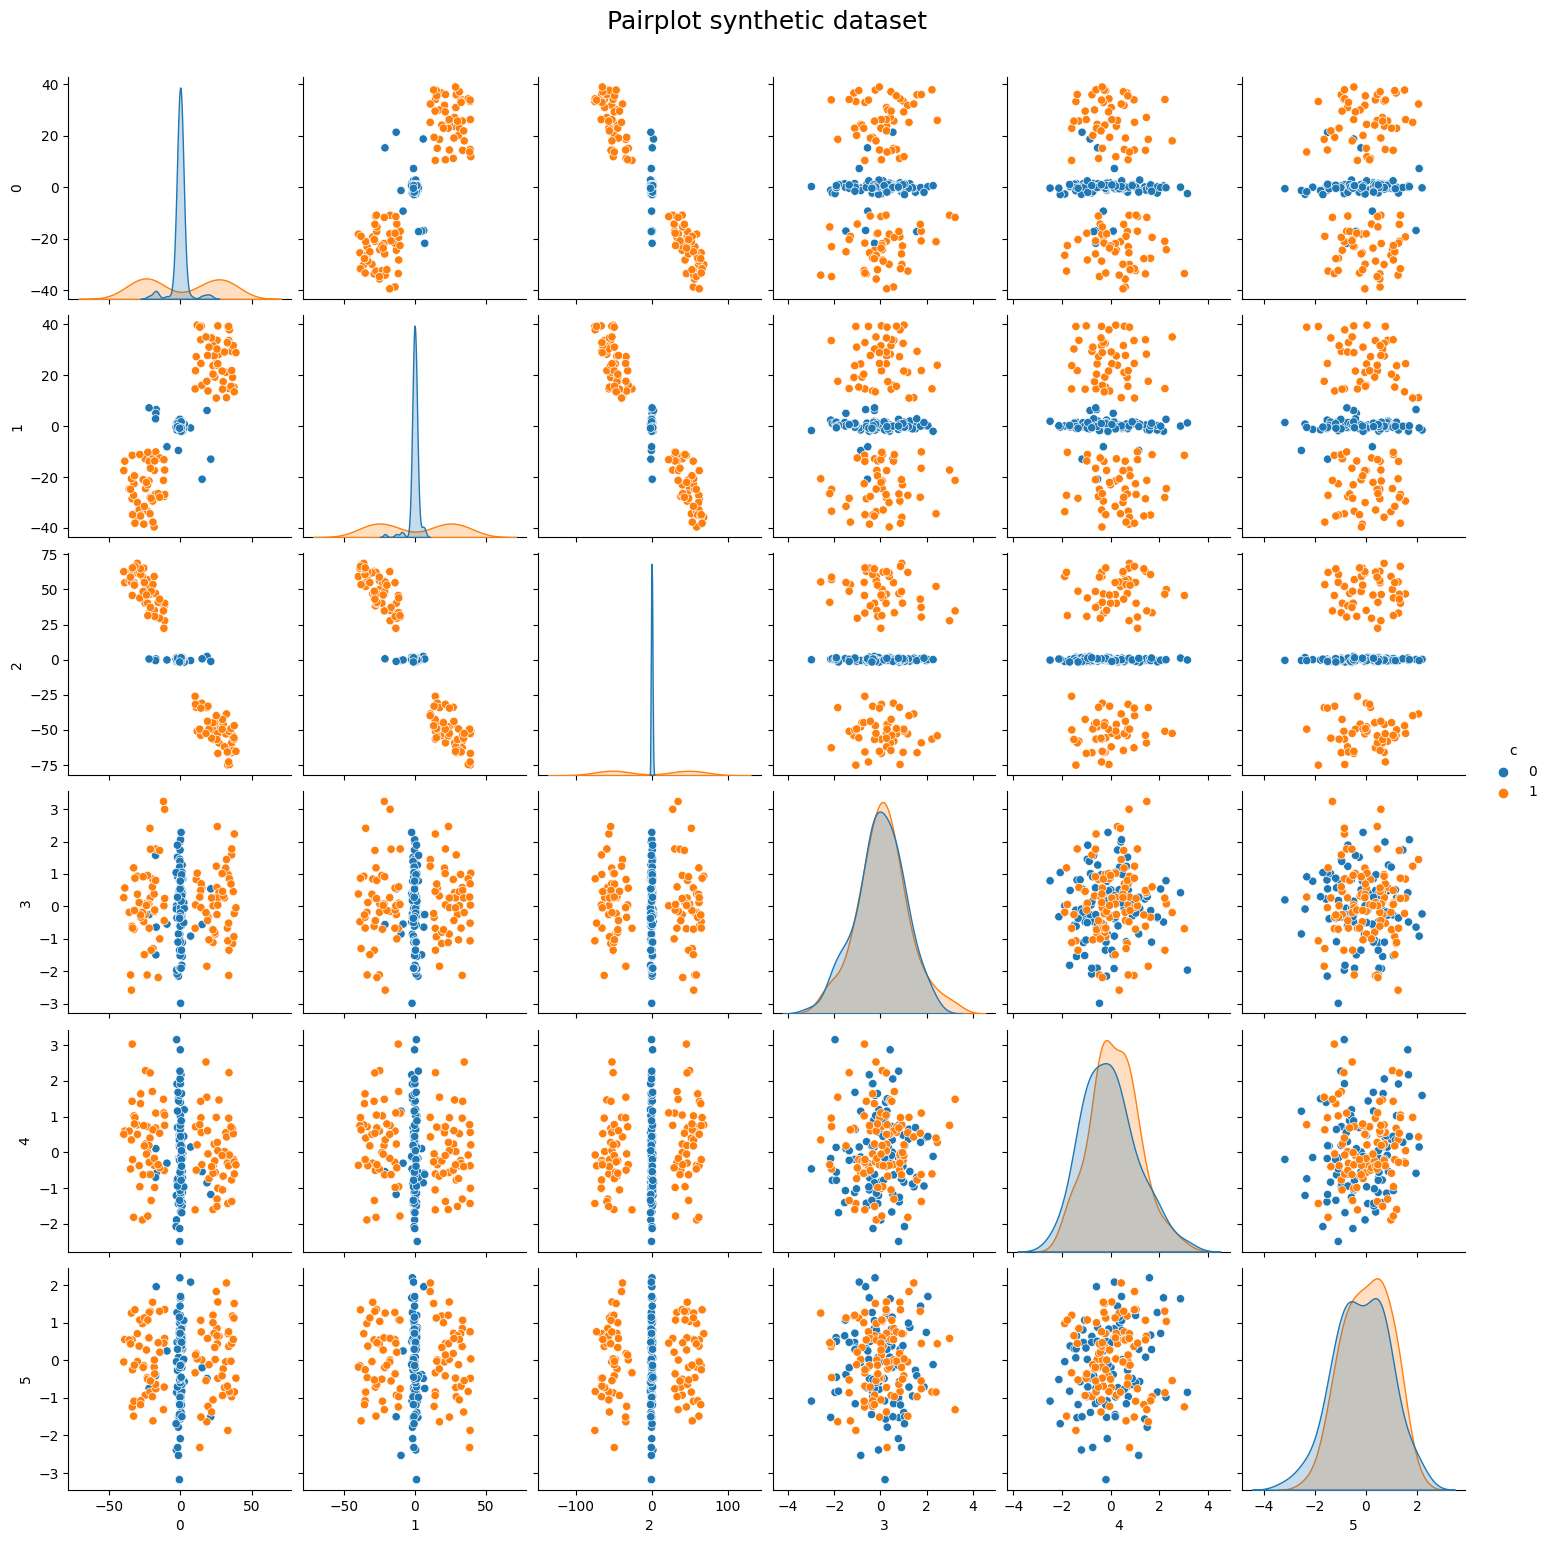

In [29]:
a = pd.DataFrame(X_train);a['c'] = 0
b = pd.DataFrame(X_bisec_3d);b['c'] = 1
df = pd.concat([a.sample(100),b],axis=0,ignore_index=True)
pairplot = sns.pairplot(data=df,hue='c')
pairplot.fig.suptitle("Pairplot synthetic dataset",y=1.03,fontsize=18)
plt.show()

### X_bisec_4d

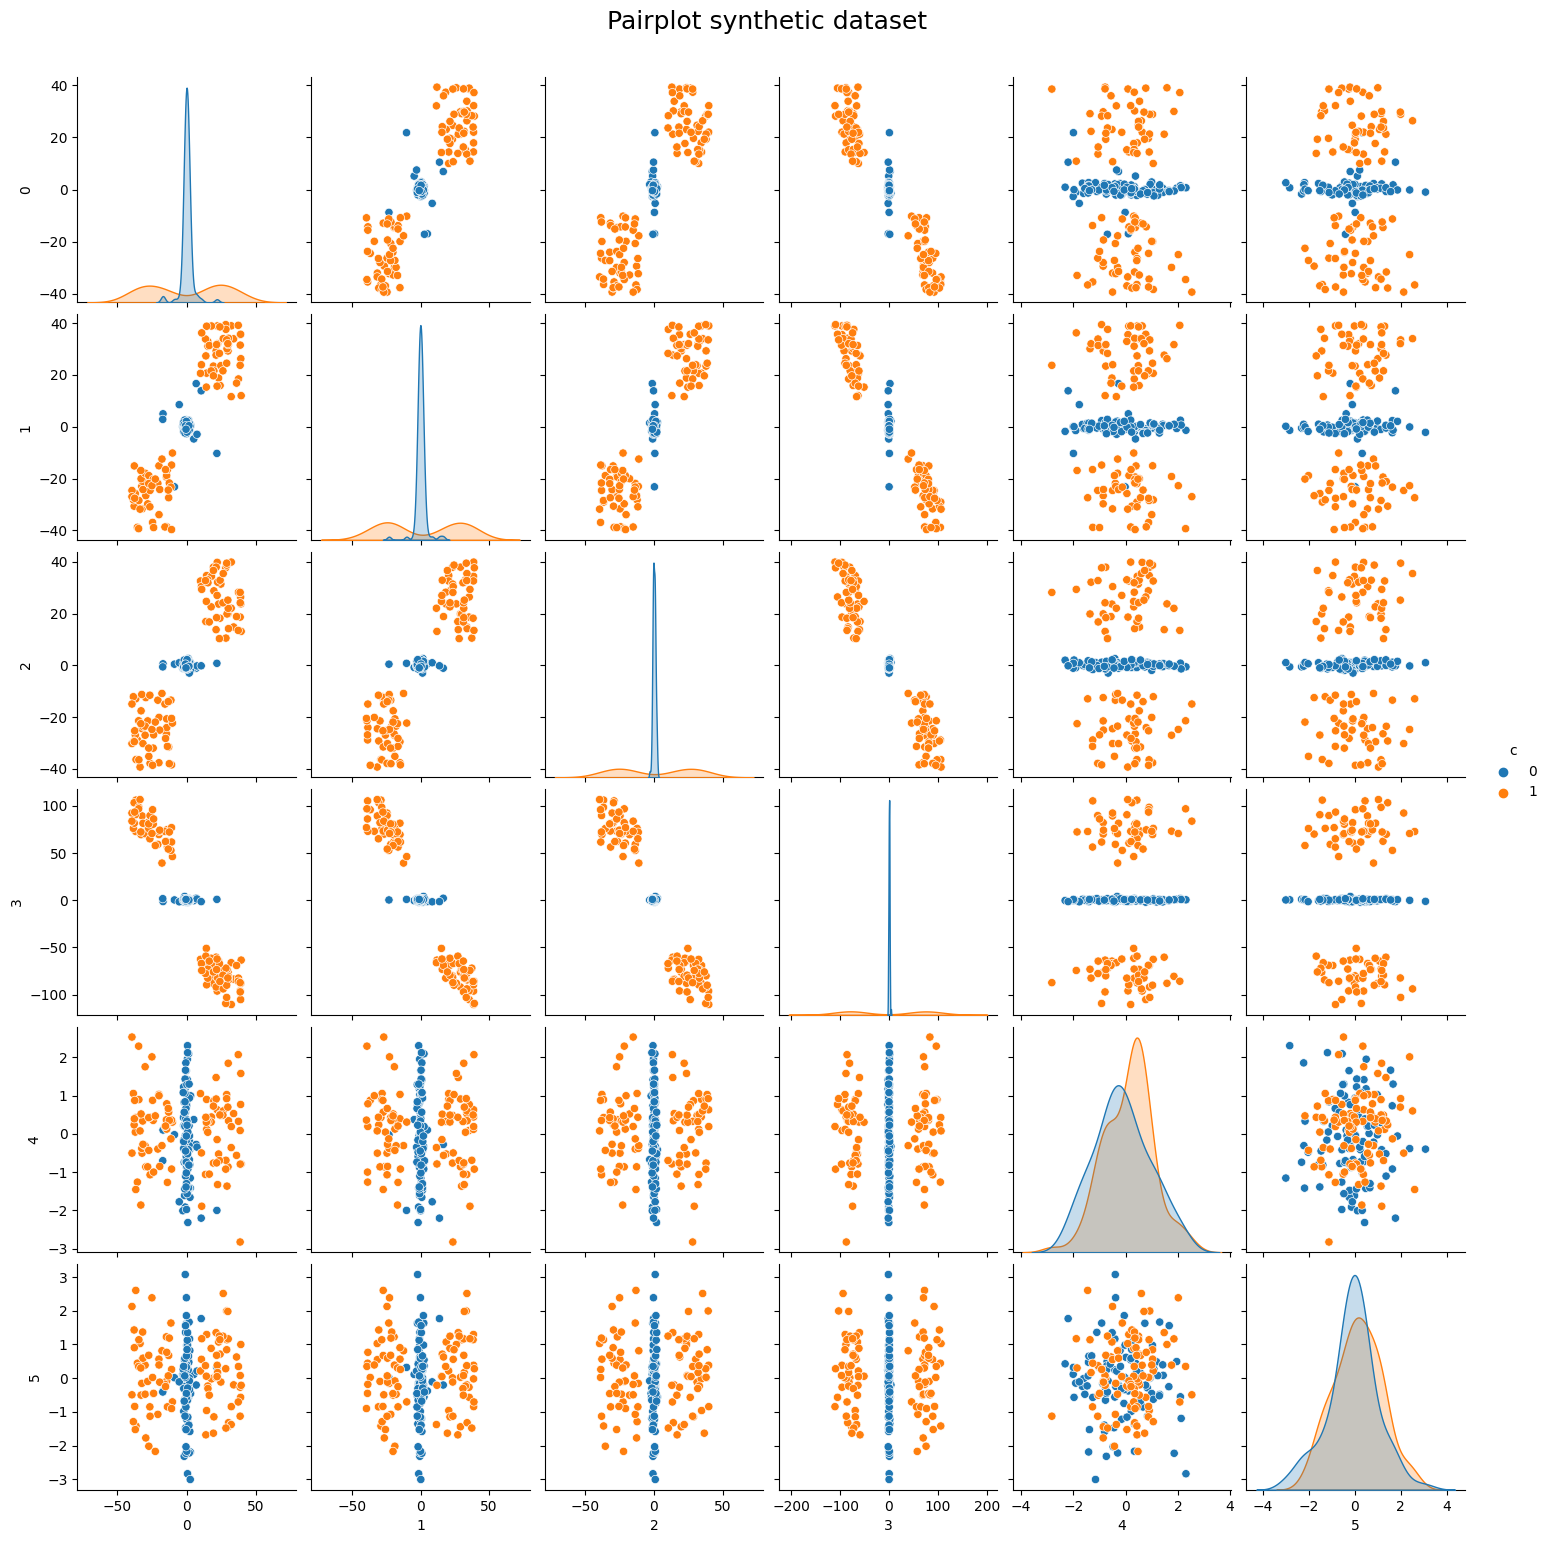

In [30]:
a = pd.DataFrame(X_train);a['c'] = 0
b = pd.DataFrame(X_bisec_4d);b['c'] = 1
df = pd.concat([a.sample(100),b],axis=0,ignore_index=True)
pairplot = sns.pairplot(data=df,hue='c')
pairplot.fig.suptitle("Pairplot synthetic dataset",y=1.03,fontsize=18)
plt.show()

### X_bisec_6d

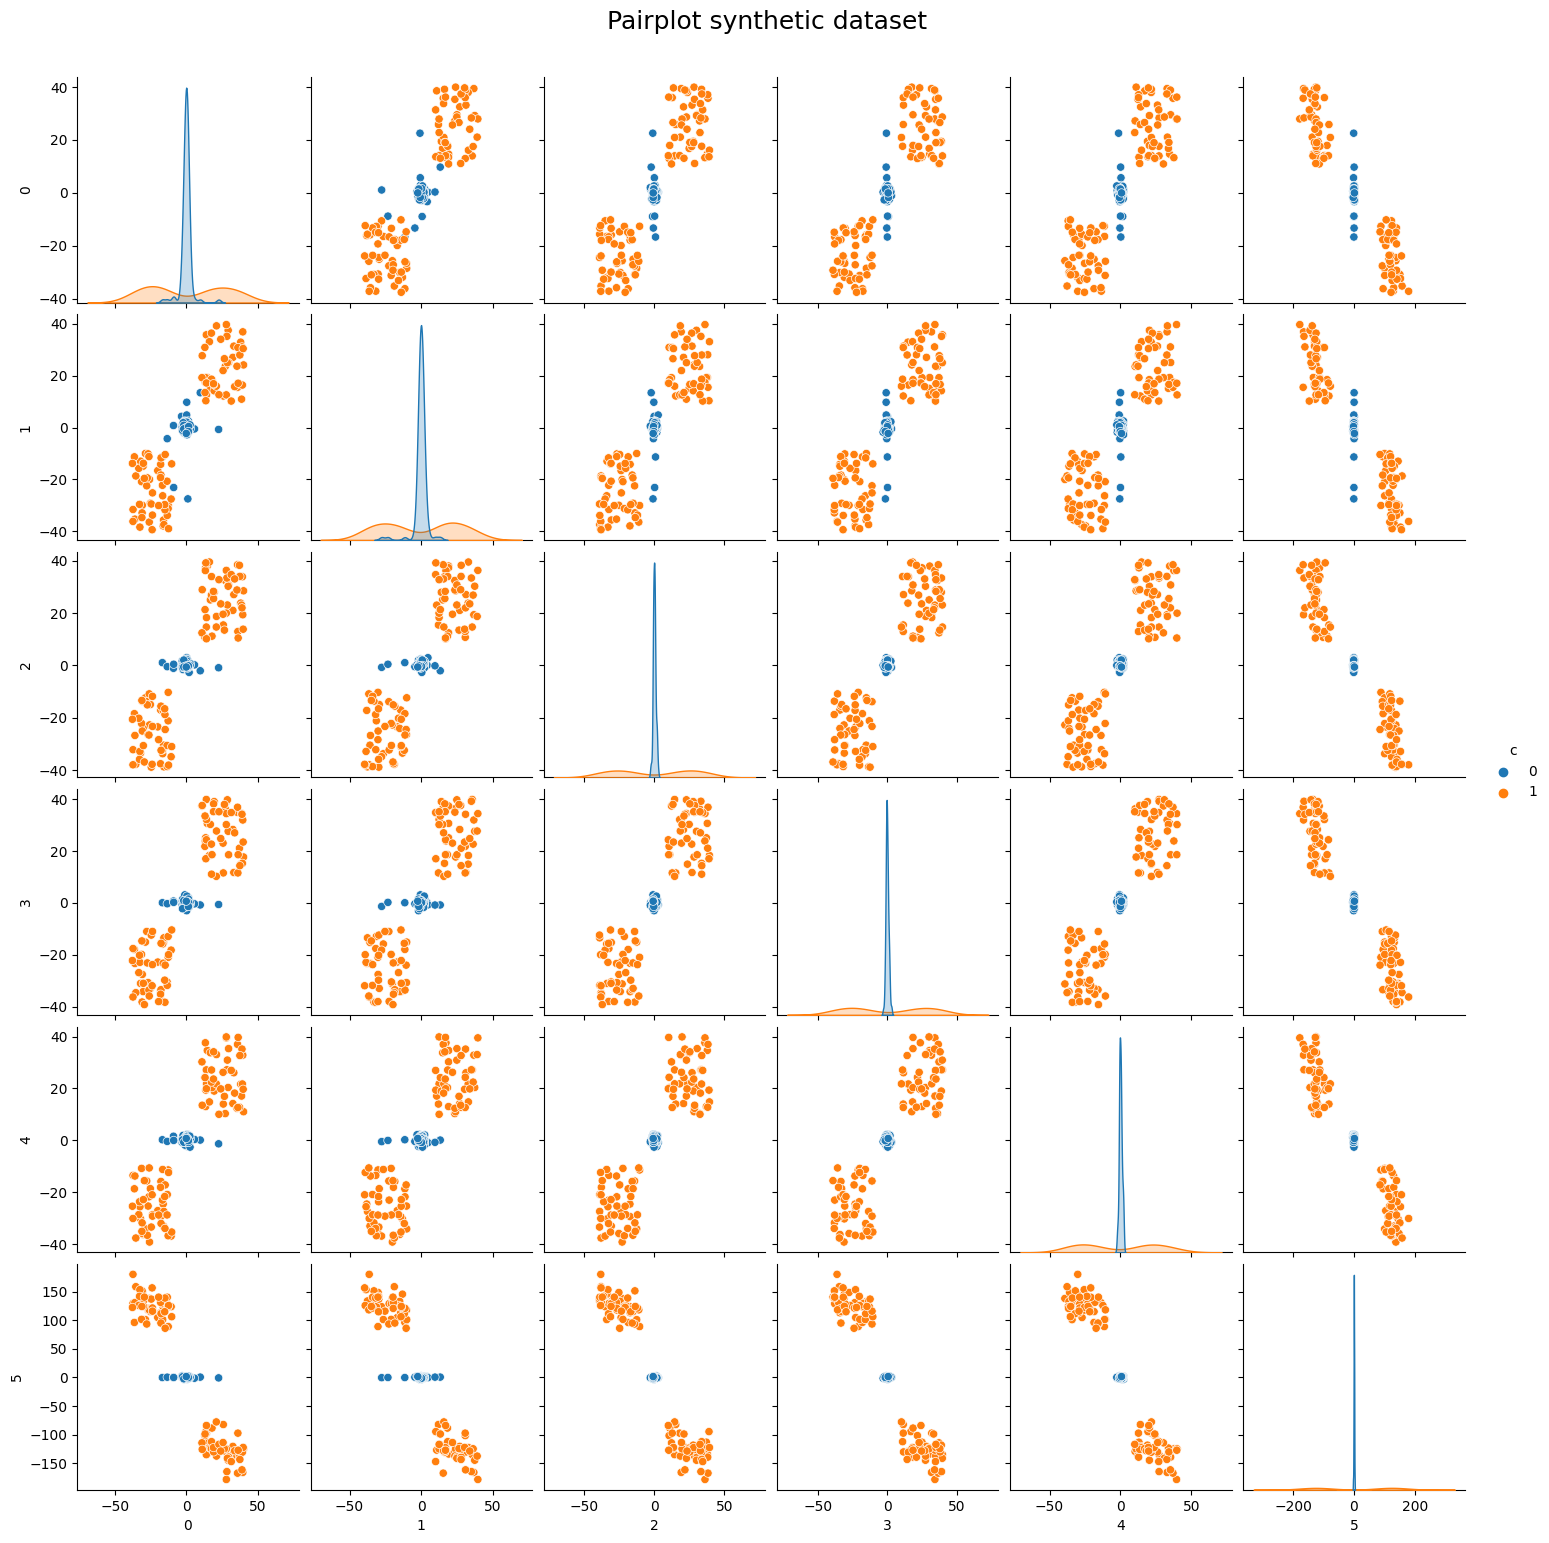

In [31]:
a = pd.DataFrame(X_train);a['c'] = 0
b = pd.DataFrame(X_bisec_6d);b['c'] = 1
df = pd.concat([a.sample(100),b],axis=0,ignore_index=True)
pairplot = sns.pairplot(data=df,hue='c')
pairplot.fig.suptitle("Pairplot synthetic dataset",y=1.03,fontsize=18)
plt.show()

### X_anti_bisect

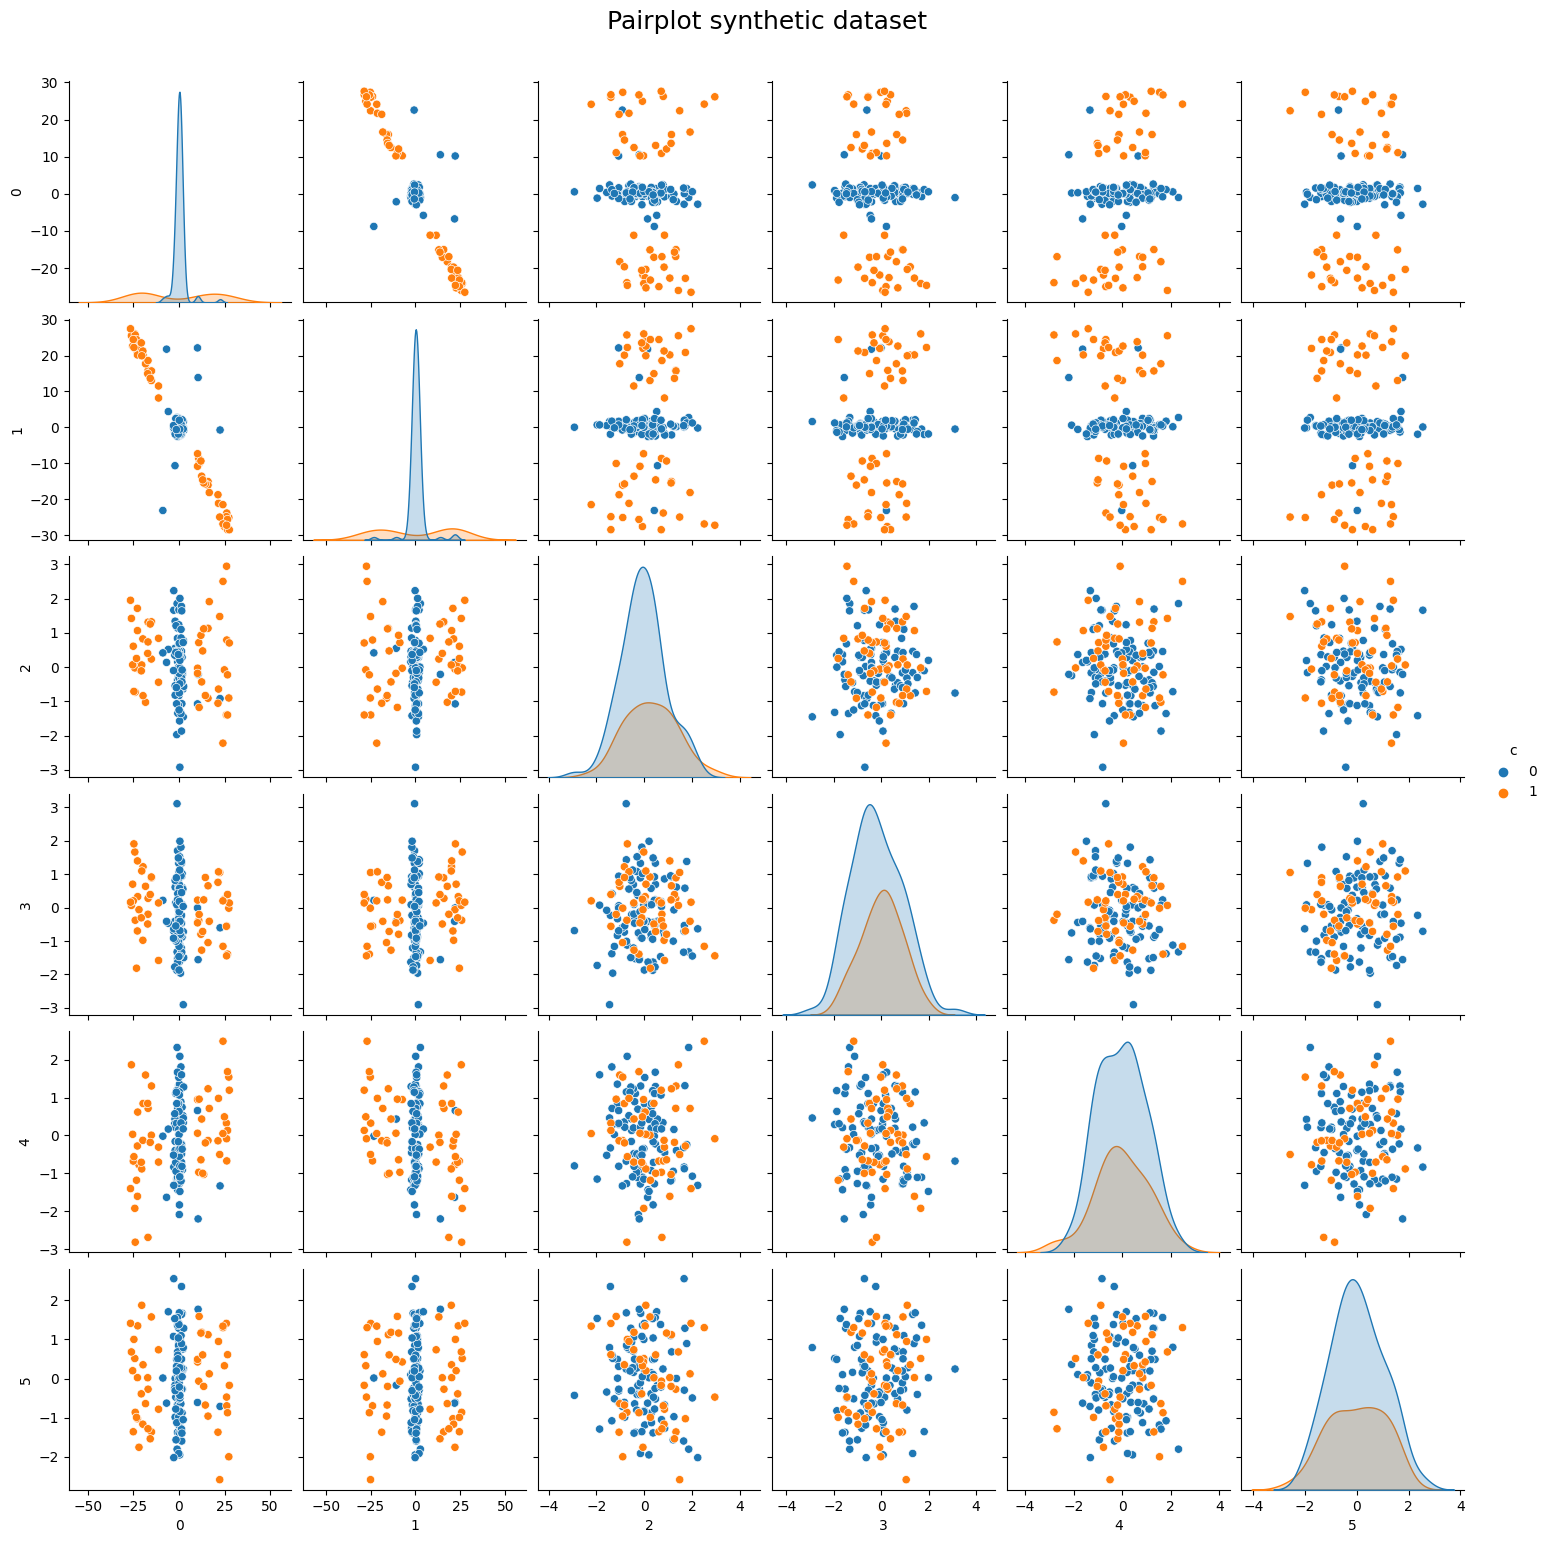

In [37]:
a = pd.DataFrame(X_train);a['c'] = 0
b = pd.DataFrame(X_anti_bisec);b['c'] = 1
df = pd.concat([a.sample(100),b],axis=0,ignore_index=True)
pairplot = sns.pairplot(data=df,hue='c')
pairplot.fig.suptitle("Pairplot synthetic dataset",y=1.03,fontsize=18)
plt.show()

### X_line

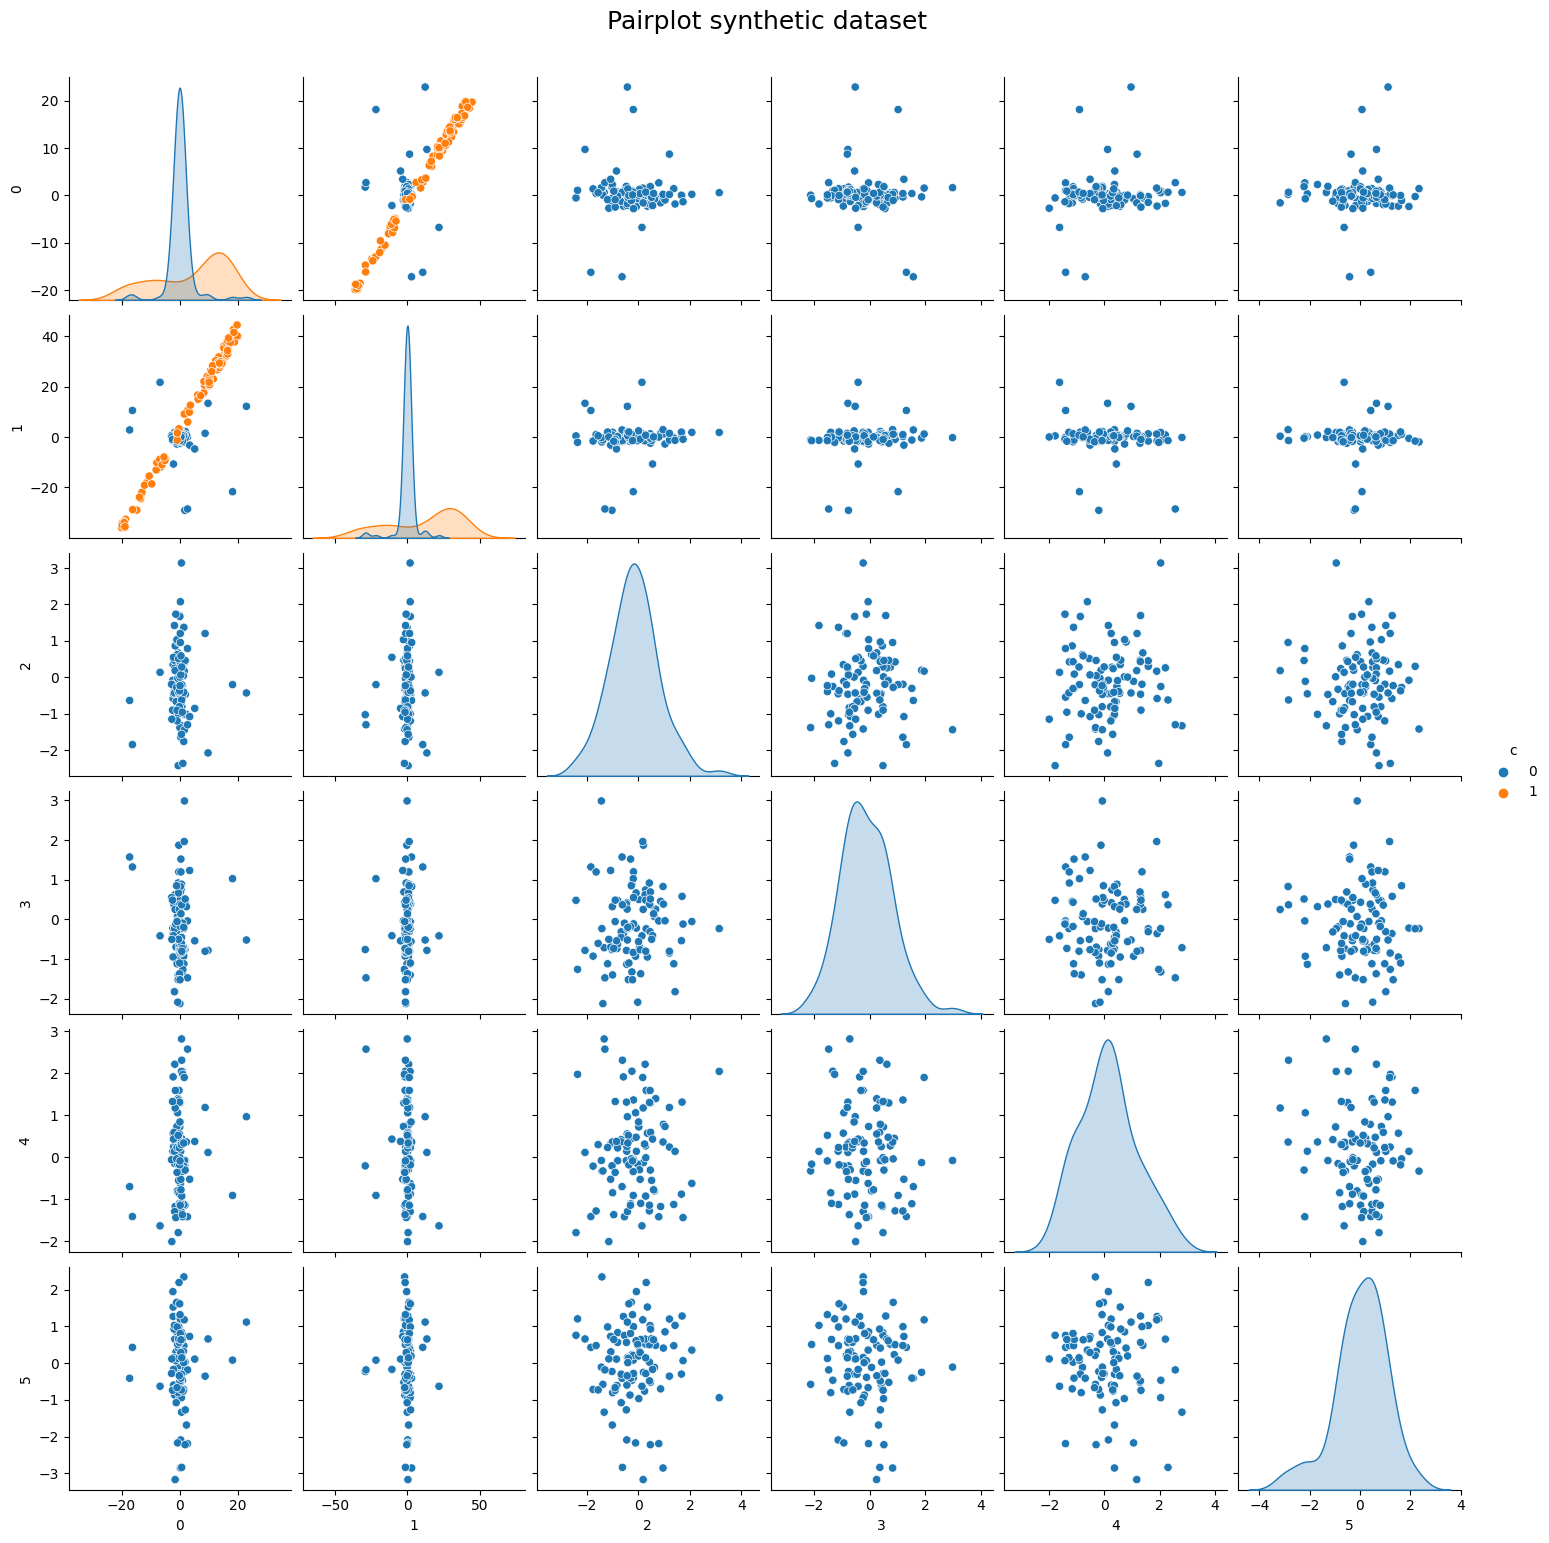

In [34]:
a = pd.DataFrame(X_train);a['c'] = 0
b = pd.DataFrame(X_line);b['c'] = 1
df = pd.concat([a.sample(100),b],axis=0,ignore_index=True)
pairplot = sns.pairplot(data=df,hue='c')
pairplot.fig.suptitle("Pairplot synthetic dataset",y=1.03,fontsize=18)
plt.show()

In [28]:
a=np.array([4,3,1,6,8,0,1,5])
np.sort(a)[::-1]

array([8, 6, 5, 4, 3, 1, 1, 0])

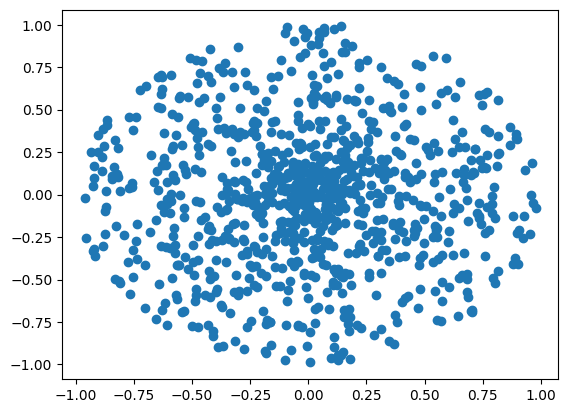

In [32]:
plt.scatter(X_train[:,0],X_train[:,1])
#plt.xlim(0)
plt.show()

# Try some stuff 

In [3]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data'

In [4]:
def partition_data(model,X,contamination=0.1):
    anomaly_scores = model.Anomaly_Score(X)
    ind = np.argpartition(anomaly_scores,-int(0.1*len(X)))[-int(0.1*len(X)):]
    inliers_idx=np.delete(range(len(X)),ind)

    inliers=X[inliers_idx]
    outliers=X[ind]
    return inliers,outliers,ind

In [5]:
X,y=dataset('breastw',os.getcwd()+'\\')
X,y=downsample(X,y)

breastw 

[numero elementi = 449]
[percentage outliers = 0.5256124721603563]
[number features = 9]
[number outliers = 236]


In [6]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)

In [7]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size)
EDIFFI.fit(X)
X_train,X_test,ind=partition_data(EDIFFI,X)

In [8]:
X_train.shape,X_test.shape

((405, 9), (44, 9))

### NEW IMPORTANCE SCORE IDEA 

See Details in ExIFFI_TO_DO

In [17]:
X_train_mean=np.mean(X_train,axis=0)

In [18]:
X_train_mean

array([5.17283951, 3.77283951, 3.90617284, 3.44938272, 3.48641975,
       4.68395062, 3.97037037, 3.52839506, 1.5382716 ])

In [20]:
LFI_plus_scores=X_test-X_train_mean
LFI_plus_scores.shape

(44, 9)

In [21]:
np.mean(LFI_plus_scores,axis=0)

array([2.09988777, 4.59079686, 3.75291807, 3.02789001, 4.01358025,
       1.24786756, 2.34781145, 3.06251403, 3.82536476])

In [53]:
np.log(np.abs(X_test[0,:]-X_train_mean))

array([-2.17656318e+00, -7.11200135e-02, -2.51023096e+00,  5.83034559e-01,
       -1.02107838e+00, -3.44467943e+01,  1.29228773e+00,  1.39079921e-02,
        5.14993054e-01, -9.42709000e-01,  3.55060993e-01, -8.83898676e-02,
        2.29493149e-01, -3.22198032e+00, -3.54324380e-01, -8.45800599e-01,
       -2.94675348e-01,  8.94153479e-01,  8.70769439e-01,  9.66422771e-01,
       -6.01923695e-01])

Function to compute this new LFI score. Putting this in input to plt_feat_bar_plot we can obtain another type of Feature Importance plot. 

In [ ]:
def LFI_plus(X_train,X_test):
    X_train_mean=np.mean(X_train,axis=0)
    LFI_plus_scores=X_test-X_train_mean
    return LFI_plus_scores

## TRY FEATURE IMPORTANCE PLOT

In [2]:
def plt_importances_bars(importances, name, pwd, dim, f = 6):
    
    if 'GFI_' not in name:
        name='LFI_'+name

    
    number_colours = 20
    color = plt.cm.get_cmap('tab20',number_colours).colors
    patterns = [None, "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

    importances_matrix = np.array([np.array(pd.Series(x).sort_values(ascending = False).index).T for x in importances])
    bars = [[(list(importances_matrix[:,j]).count(i)/len(importances_matrix))*100 for i in range(dim)] for j in range(dim)]
    
    bars = pd.DataFrame(bars)
    display(bars)

    tick_names=[]
    for i in range(1,f+1):
        if i==1:
            tick_names.append(r'${}'.format(i) + r'^{st}$')
        elif i==2:
            tick_names.append(r'${}'.format(i) + r'^{nd}$')
        elif i==3:
            tick_names.append(r'${}'.format(i) + r'^{rd}$')
        else:
            tick_names.append(r'${}'.format(i) + r'^{th}$')

    barWidth = 0.85
    r=range(dim)
 
    for i in range(dim):
        plt.bar(r[:f], bars.T.iloc[i,:f].values, bottom=bars.T.iloc[:i,:f].sum().values ,color=color[i%number_colours], edgecolor='white', width=barWidth, label=str(i), hatch=patterns[i//number_colours])


    plt.xlabel("rank", fontsize = 14)
    #plt.xticks(range(f),[r'$1^{st}$', r'$2^{nd}$', r'$3^{rd}$', r'$4^{th}$', r'$5^{th}$', r'$6^{th}$', r'$7^{th}$', r'$8^{th}$', r'$9^{th}$'][:f])
    plt.xticks(range(f),tick_names[:f])
    plt.ylabel("Percentage count", fontsize = 14)
    plt.yticks(range(10,101,10),[str(x)+"%" for x in range(10,101,10)])
    plt.title("synthetic {} anomalies E-diffi \n percentage count of feature ranking".format(name,f), fontsize = 18)
    plt.legend(bbox_to_anchor = (1.05,0.95),loc="upper left")
    #plt.savefig(pwd+'/results_local_diffi/images/'+name+'.pdf',bbox_inches = "tight")
    #current_time=datetime.now()
    #tm=[current_time.day,current_time.month,current_time.year,
    #current_time.hour,current_time.minute,current_time.second]
    plt.savefig(pwd+'//results//davide/{}_synt.pdf'
                .format(name),bbox_inches='tight')
    plt.show()

In [3]:
def plt_global_importance_bars(model,X_train,X_test,n_runs,name,pwd,dim,f=6):

    name='GFI_'+name

    #X_test=np.r_[X_train,X_test]

    imps=np.zeros(shape=(n_runs,X_train.shape[1]))
    for i in tqdm(range(n_runs)):
        model.fit(X_train)
        imps[i,:]=model.Global_importance(X_test,calculate=True,sovrascrivi=False,depth_based=False)

    #Take the mean feature importance scores over the different runs for the Feature Importance Plot
    #and put it in decreasing order of importance
    mean_imp=np.mean(imps,axis=0)
    std_imp=np.std(imps,axis=0)
    mean_imp_val=np.sort(mean_imp)
    feat_order=mean_imp.argsort()

    plt_data={'Importances': mean_imp_val,
              'feat_order': feat_order,
              'std': std_imp[mean_imp.argsort()]}

    
    plt_importances_bars(imps,name,pwd,dim,f)
    plt_feat_bar_plot_1(plt_data,name,f)

In [4]:
def plt_feat_bar_plot(global_importances,X,name,pwd,f=6):
    
    name_file='Feat_bar_plot_'+name 
    patterns = [None, "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

    imp_vals=global_importances['Importances']

    feat_imp=pd.DataFrame({'Global Importance': np.round(imp_vals,3),
                          'Feature': global_importances['feat_order'],
                          'std': global_importances['std'][::-1]
                          })
    
    dim=imp_vals.shape[0]

    number_colours = 20
    
    color = plt.cm.get_cmap('tab20',number_colours).colors

    #color = plt.cm.get_cmap('tab20',number_colours).colors
    ax=feat_imp.plot(y='Global Importance',x='Feature',kind="barh",color=color,xerr=feat_imp['std'],
                     capsize=5, alpha=0.7,legend=False,
                     hatch=[patterns[i//number_colours] for i in range(dim)])

    barWidth=0.85
    
    r=range(dim)

    #for i in range(dim):
        #plt.bar(r[:f], feat_imp.T.iloc[i,:f].values, bottom=feat_imp.T.iloc[:i,:f].sum().values ,color=color[i%number_colours], edgecolor='white', width=barWidth, label=str(i), hatch=patterns[i//number_colours])
        #plt.barh(i,imp_vals[dim-i-1],color=color[(dim-i-1)%number_colours],hatch=patterns[i//number_colours],edgecolor='white')

    xlim=np.min(imp_vals)-0.2*np.min(imp_vals)

    #The position for the importance values should be the mean between xlim and the importance value.
    #Let's put all the correct positions on a list 
    text=[np.mean([xlim,x]) + 7*y for x,y in zip(imp_vals,feat_imp['std'])]

    text_x=np.max(feat_imp['Global Importance']) + 3*np.mean(feat_imp['std'])

    for i, v in enumerate(feat_imp['Global Importance']):
        #ax.text(text[i],i-0.2,str(v)+' +- ' + str(np.round(feat_imp['std'][i],2)), ha='center', va='bottom')
        ax.text(text_x,i-0.2,str(v)+' +- ' + str(np.round(feat_imp['std'][dim-1-i],2)), ha='center', va='bottom')


    plt.title("GFI Feature Importance Plot "+name)
    plt.axvline(x=0, color=".5")
    plt.xlim(xlim)
    plt.yticks(range(dim),global_importances['feat_order'])
    plt.subplots_adjust(left=0.3)
    plt.savefig(pwd+'//results//davide/{}.pdf'.format(name_file),bbox_inches='tight')
    plt.show()


In [8]:
def plt_feat_bar_plot_1(global_importances,name,f=6):
    
    name_file='Feat_bar_plot_'+name 
    patterns = [None, "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

    imp_vals=global_importances['Importances']

    feat_imp=pd.DataFrame({'Global Importance': np.round(imp_vals,3)[::-1],
                          'Feature': global_importances['feat_order'],
                          'std': global_importances['std']
                          })
    
    dim=imp_vals.shape[0]

    number_colours = np.max([dim,20])
    
    #color = plt.cm.get_cmap('tab20',number_colours).colors[global_importances['feat_order']]

    color = plt.cm.get_cmap('tab20',number_colours).colors
    
    ax=feat_imp.plot(y='Global Importance',x='Feature',kind="barh",color=color,xerr=feat_imp['std'],
                     capsize=10, alpha=0.7,legend=False,
                     hatch=[patterns[i//number_colours] for i in range(dim)])

    barWidth=0.85
    
    r=range(dim)

    #for i in range(dim):
        #plt.bar(r[:f], feat_imp.T.iloc[i,:f].values, bottom=feat_imp.T.iloc[:i,:f].sum().values ,color=color[i%number_colours], edgecolor='white', width=barWidth, label=str(i), hatch=patterns[i//number_colours])
        #plt.barh(dim-i-1,imp_vals[i],color=color[i%number_colours],hatch=patterns[i//number_colours],edgecolor='white')
        #plt.barh(dim-i-1,imp_vals[i],color=color[i],hatch=patterns[i//number_colours],edgecolor='white')

    xlim=np.min(imp_vals)-0.2*np.min(imp_vals)

    #The position for the importance values should be the mean between xlim and the importance value.
    #Let's put all the correct positions on a list 
    text=[np.mean([xlim,x]) +2*y for x,y in zip(imp_vals,feat_imp['std'])]

    for i, v in enumerate(feat_imp['Global Importance']):
        ax.text(text[i],i-0.2,str(v), ha='center', va='bottom')


    plt.title("GFI Feature Importance Plot "+name)
    plt.axvline(x=0, color=".5")
    plt.xlim(xlim)
    plt.yticks(range(dim),global_importances['feat_order'])
    plt.subplots_adjust(left=0.3)
    #plt.savefig(pwd+'//results//davide/{}.pdf'
       #         .format(name_file),bbox_inches='tight')
    plt.show()

Try on Wine

In [43]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data'

In [45]:
def partition_data(X,y):
    inliers=X[y==0,:]
    outliers=X[y==1,:]
    return inliers,outliers

In [46]:
X,y=dataset('wine',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

wine 

[numero elementi = 129]
[percentage outliers = 0.07751937984496124]
[number features = 13]
[number outliers = 10]


In [ ]:
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)

In [48]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size)
EDIFFI.fit(X_train)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:01<00:00, 18.10s/it]


0     1     2     3     4     5     6     7     8     9     10    11  \
0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   10.0   0.0   0.0   0.0   0.0  10.0  40.0   0.0  10.0   0.0  10.0  20.0   
2   20.0   0.0  20.0  10.0  20.0   0.0  20.0   0.0   0.0   0.0  10.0   0.0   
3   10.0   0.0  10.0  20.0  20.0  10.0   0.0  10.0   0.0   0.0  10.0  10.0   
4    0.0   0.0  20.0  10.0  10.0   0.0  20.0   0.0  30.0   0.0  10.0   0.0   
5    0.0   0.0   0.0  20.0   0.0   0.0   0.0  10.0  30.0  10.0  10.0  20.0   
6   20.0   0.0  20.0   0.0  10.0   0.0  20.0   0.0  10.0  20.0   0.0   0.0   
7   30.0   0.0   0.0  10.0   0.0  20.0   0.0   0.0  20.0   0.0  10.0  10.0   
8    0.0  20.0  20.0  10.0   0.0  20.0   0.0  10.0   0.0  10.0  10.0   0.0   
9    0.0  10.0  10.0  20.0  10.0  10.0   0.0  20.0   0.0   0.0  10.0  10.0   
10  10.0  10.0   0.0   0.0  10.0  20.0   0.0   0.0   0.0  40.0   0.0  10.0   
11   0.0  20.0   0.0   0.0  20.0  10.0   0.0  20.0   0.0  20.0   0.0  10.0   
12   0.0  40.0   0.0   0.0   0.0   0.0   0.0  30.0   0.0   0.0  20.0  10.0   

       12  
0   100.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9     0.0  
10    0.0  
11    0.0  
12    0.0

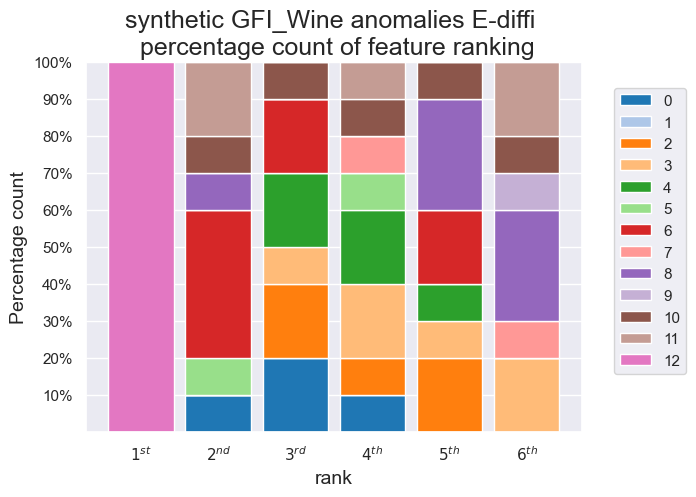

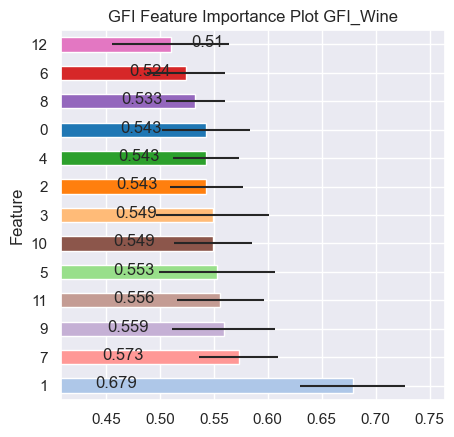

In [53]:
name='Wine'
X_test=np.r_[X_train,X_test]
plt_global_importance_bars(EDIFFI,X_train,X_test,10,name,pwd,dim)

Feature Importance Plot Tests

In [69]:
color = plt.cm.get_cmap('tab20',20).colors
color30 = plt.cm.get_cmap('tab20',30).colors
color6=plt.cm.get_cmap('tab20',6).colors

In [71]:
color[1,:],color30[1,:],color6[1,:]

(array([0.68235294, 0.78039216, 0.90980392, 1.        ]),
 array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 array([0.17254902, 0.62745098, 0.17254902, 1.        ]))

X_xaxis

In [31]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data'

In [32]:
file_to_read = open(os.getcwd()+'\\syn_train_100.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_train,y_train= loaded_dictionary['X_train'],loaded_dictionary['y_train']

In [33]:
file_to_read = open(os.getcwd()+'\\syn_test.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_xaxis,X_yaxis,X_bisec = loaded_dictionary['X_xaxis'],loaded_dictionary['X_yaxis'],loaded_dictionary['X_bisec']

In [35]:
N = X_train.shape[0]
dim = X_train.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10

In [36]:
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size)
EDIFFI.fit(X_train)

In [38]:
X_test=np.r_[X_train,X_xaxis]

In [56]:
imps=np.zeros(shape=(10,X_train.shape[1]))
for i in tqdm(range(10)):
    EDIFFI.fit(X_train)
    imps[i,:]=EDIFFI.Global_importance(X_test,calculate=True,sovrascrivi=False,depth_based=False)

#Take the mean feature importance scores over the different runs for the Feature Importance Plot
#and put it in decreasing order of importance
mean_imp=np.mean(imps,axis=0)
std_imp=np.std(imps,axis=0)
mean_imp_val=np.sort(mean_imp)
feat_order=mean_imp.argsort()

plt_data={'Importances': mean_imp_val,
            'feat_order': feat_order,
            'std': std_imp[mean_imp.argsort()]}

100%|██████████| 10/10 [07:13<00:00, 43.34s/it]


In [40]:
plt_data['Importances']

array([5.22764214, 5.32886156, 5.34333385, 5.42799825, 5.43900048,
       7.0039211 ])

In [41]:
plt_data['feat_order']

array([2, 3, 1, 5, 4, 0], dtype=int64)

In [43]:
std_imp

array([0.75060824, 0.6779418 , 0.64047747, 0.53701174, 0.69715369,
       0.59626503])

In [50]:
plt_data['std']=plt_data['std'][::-1]

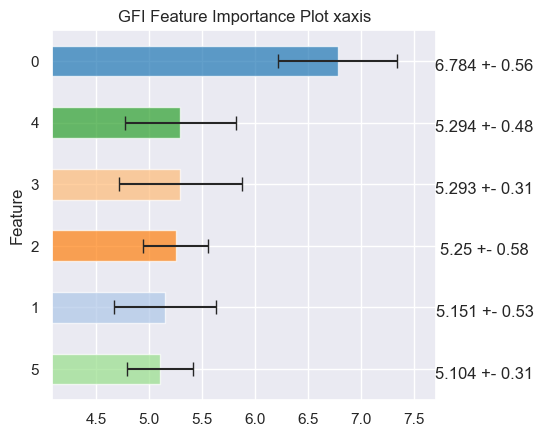

In [71]:
plt_feat_bar_plot(plt_data,'xaxis')

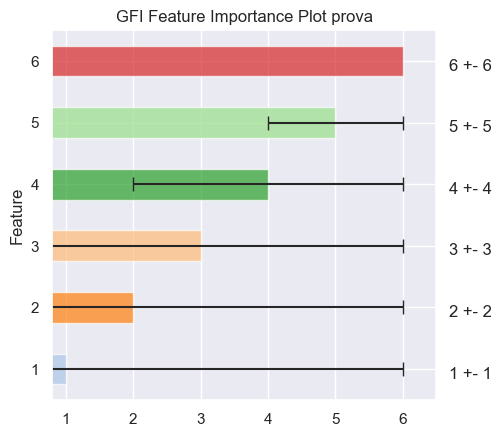

In [59]:
plt_prova=pd.DataFrame({'Importances': [1,2,3,4,5,6],
                     'feat_order':[1,2,3,4,5,6],
                     'std': [1,2,3,4,5,6][::-1]})
plt_feat_bar_plot(plt_prova,'prova')

In [29]:
df_xaxis=pd.DataFrame({'Importances': [2.133,2.219,2.221,2.228,2.24,3.841],
                     'feat_order':[1,4,2,3,5,0],
                     'std': [0.22,0.11,0.09,0.19,0.18,0.3]})

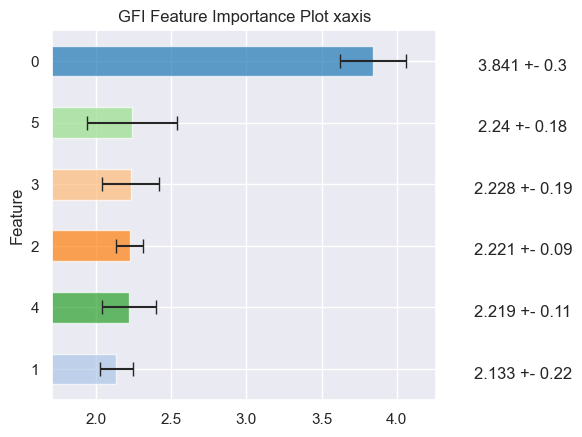

In [30]:
plt_feat_bar_plot(df_xaxis,'xaxis')

Cardio

In [16]:
df_cardio=pd.DataFrame({'Importances': [1.073,1.017,1.009,0.977,0.97,0.963,0.943,0.936,0.92,0.916,0.911,0.911,0.91,0.907,0.906,0.903,0.903,0.902,0.9,0.899,0.898],
                     'feat_order':[6,2,5,19,9,16,17,8,13,18,11,4,20,15,0,12,3,1,7,14,10]})

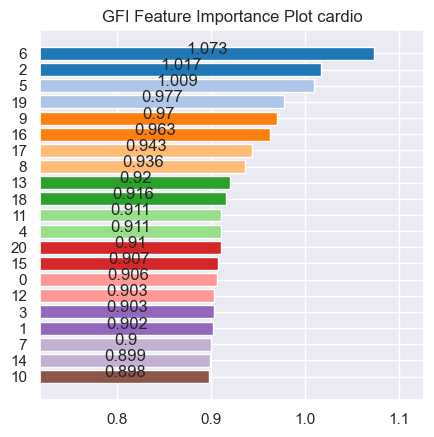

In [34]:
plt_feat_bar_plot(df_cardio,'cardio')

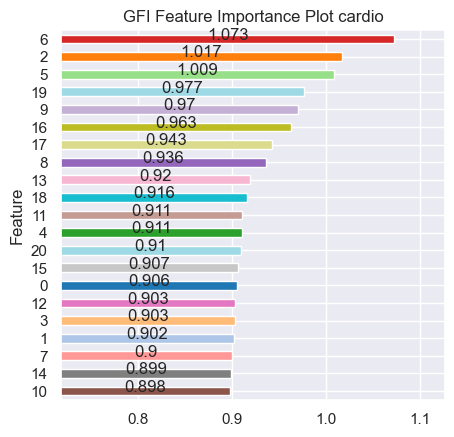

In [17]:
df_cardio=pd.DataFrame({'Importances': [1.073,1.017,1.009,0.977,0.97,0.963,0.943,0.936,0.92,0.916,0.911,0.911,0.91,0.907,0.906,0.903,0.903,0.902,0.9,0.899,0.898][::-1],
                     'feat_order':[6,2,5,19,9,16,17,8,13,18,11,4,20,15,0,12,3,1,7,14,10][::-1]})
plt_feat_bar_plot_1(df_cardio,'cardio')

Ionosphere

In [8]:
sns.set()

In [29]:
df_ionosphere=pd.DataFrame({'Importances':[2.141,2.081,2.058,2.056,2.055,2.05,2.047,2.046,2.044,2.034,2.033,2.027,2.024,2.024,2.023,2.023,2.023,2.016,2.016,2.013,2.01,2.01,2.01,2.009,2.009,2.004,2.004,1.998,1.997,1.993,1.99,1.973,1.955],
                           'feat_order': [1,3,16,11,0,7,12,2,25,26,5,20,10,4,17,29,19,23,6,9,18,15,14,27,24,8,21,28,30,13,32,22,31]})

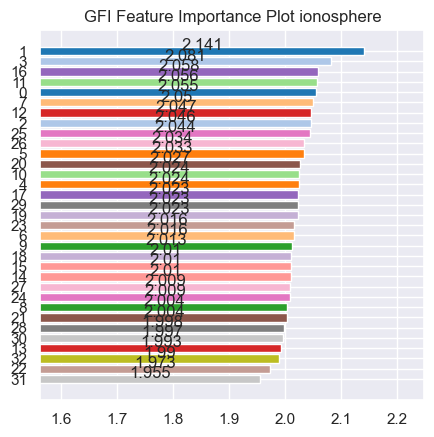

In [30]:
plt_feat_bar_plot(df_ionosphere,'ionosphere')

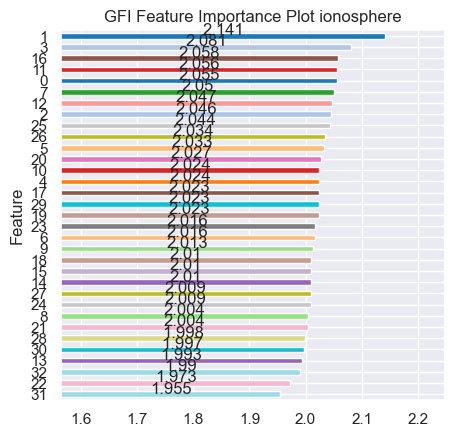

In [18]:
df_ionosphere=pd.DataFrame({'Importances':[2.141,2.081,2.058,2.056,2.055,2.05,2.047,2.046,2.044,2.034,2.033,2.027,2.024,2.024,2.023,2.023,2.023,2.016,2.016,2.013,2.01,2.01,2.01,2.009,2.009,2.004,2.004,1.998,1.997,1.993,1.99,1.973,1.955][::-1],
                           'feat_order': [1,3,16,11,0,7,12,2,25,26,5,20,10,4,17,29,19,23,6,9,18,15,14,27,24,8,21,28,30,13,32,22,31][::-1]})
plt_feat_bar_plot_1(df_ionosphere,'ionosphere')

## NEW FEAT BAR PLT IONOSPHERE

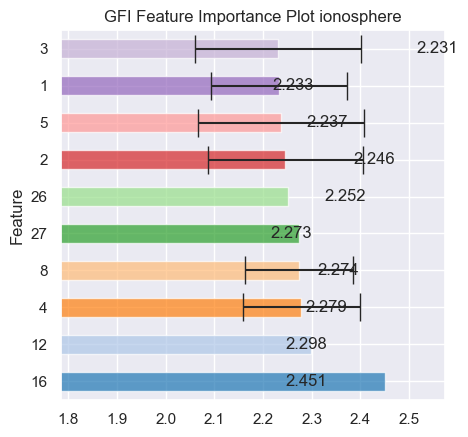

In [9]:
df_ionosphere={
    'Importances':np.array([2.231,2.233,2.237,2.246,2.252,2.273,2.274,2.279,2.298,2.451]),
    'feat_order':[16,12,4,8,27,26,2,5,1,3],
    'std':[0.14,0.14,0.16,0.17,0.12,0.17,0.2,0.15,0.11,0.22]
}
plt_feat_bar_plot_1(df_ionosphere,'ionosphere',f=6)

Annthyroid

In [31]:
df_annthyroid=pd.DataFrame({'Importances':[0.815,0.764,0.757,0.735,0.714,0.604],
                           'feat_order': [1,5,3,2,4,0]})

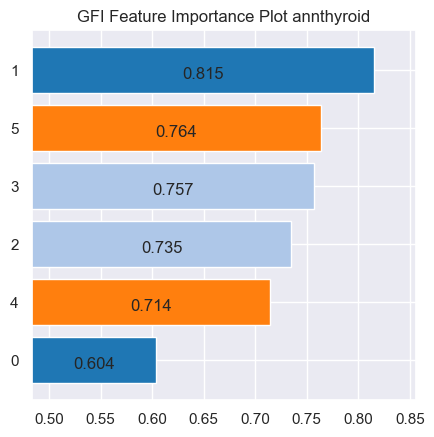

In [32]:
plt_feat_bar_plot(df_annthyroid,'annthyroid')

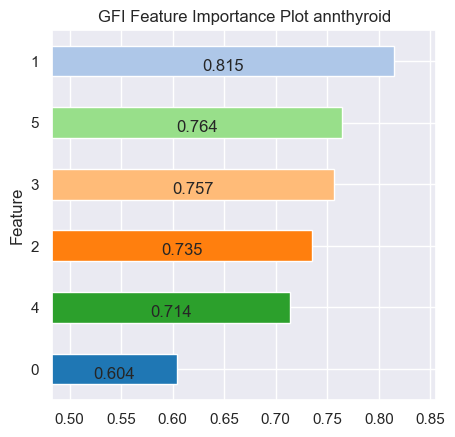

In [78]:
df_annthyroid=pd.DataFrame({'Importances':[0.815,0.764,0.757,0.735,0.714,0.604][::-1],
                           'feat_order': [1,5,3,2,4,0][::-1]})
plt_feat_bar_plot_1(df_annthyroid,'annthyroid')

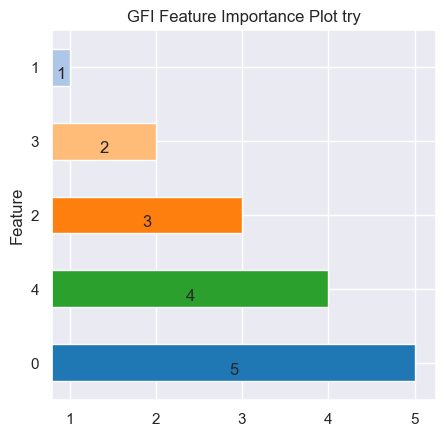

In [51]:
df_try=pd.DataFrame({'Importances':[1,2,3,4,5][::-1],
                     'feat_order':[1,3,2,4,0][::-1]})
plt_feat_bar_plot_1(df_try,'try')

#### Ionosphere First 10 

In [3]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
X,y=dataset('ionosphere',os.getcwd()+'\\')
X,y=downsample(X,y)
X_train,X_test=partition_data(X,y)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

ionosphere 

[numero elementi = 350]
[percentage outliers = 0.35714285714285715]
[number features = 33]
[number outliers = 125]


In [4]:
ind=np.random.choice(np.arange(X_test.shape[0]),int(X.shape[0]*0.1))
X_test=X_test[ind,:]
N = X.shape[0]
dim = X.shape[1]
n_trees = 200
max_depth = 25
min_subsample = 1
subsample_size = min(N,max(int(N*1/10),200))
if subsample_size>200:
    n_trees=subsample_size
    subsample_size=200
if subsample_size==N:
    subsample_size = None
precision = 10
p = sum(y)/len(y)
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
os.getcwd()
pwd = os.getcwd()
dim = X.shape[1]
EDIFFI=Extended_DIFFI_original(n_trees,max_depth=100,subsample_size=subsample_size)
EDIFFI.fit(X_train)


In [5]:
def plt_global_importance_bars(model,X_train,X_test,n_runs,name,pwd,dim,f=6):

    name='GFI_'+name

    #X_test=np.r_[X_train,X_test]

    imps=np.zeros(shape=(n_runs,X_train.shape[1]))
    for i in tqdm(range(n_runs)):
        model.fit(X_train)
        imps[i,:]=model.Global_importance(X_test,calculate=True,sovrascrivi=False,depth_based=False)

    #Take the mean feature importance scores over the different runs for the Feature Importance Plot
    #and put it in decreasing order of importance
    mean_imp=np.mean(imps,axis=0)
    std_imp=np.std(imps,axis=0)
    mean_imp_val=np.sort(mean_imp)
    feat_order=mean_imp.argsort()

    plt_data={'Importances': mean_imp_val,
              'feat_order': feat_order,
              'std': std_imp[mean_imp.argsort()]}
    
    return plt_data

In [8]:
df_ionosphere=plt_global_importance_bars(EDIFFI,X_train,X_test,10,'ionosphere',os.getcwd(),X_train.shape[1])

100%|██████████| 10/10 [01:59<00:00, 11.91s/it]


In [17]:
feat_imp={
    'Importances': df_ionosphere['Importances'][dim-10:],
    'feat_order': df_ionosphere['feat_order'][dim-10:],
    'std': df_ionosphere['std'][dim-10:]
}

In [19]:
feat_imp['feat_order']

array([20, 21,  9, 30, 31, 14,  4,  1,  5, 18], dtype=int64)

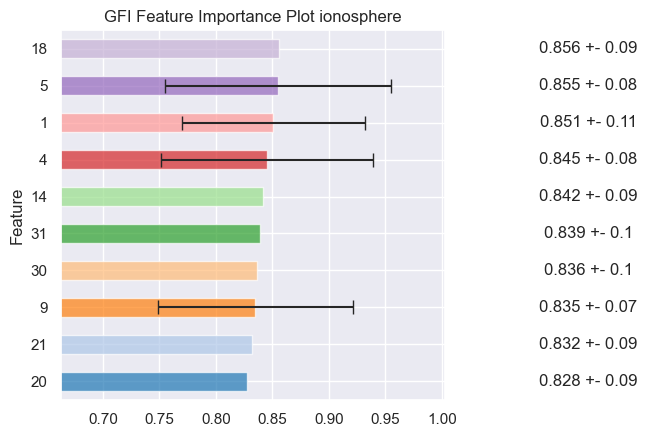

In [21]:
plt_feat_bar_plot(feat_imp,X,'ionosphere',pwd,f=6)

## N.B 

If I use plt_feat_bar_plot (so the version in which I plot the bar with plt.bar) the 'Importances' and 'feat_order' keys of the disctionary must be in DECREASING ORDER. On the other hand if I use plt_feat_bar_plot_1 (version in which I use the plot function of the dataframe) then the 'Importances' and 'feat_order' keys of the disctionary must be in INCREASING order. 

## TOY DATASET 

Code for the generation of the Toy Dataset with 2 balls centered in (0,0) and (1,1) respectively with 2 features, (0,0,0) and (1,1,1) with 3 features and so on. The remaining 6-x features are the usual white noise samples. 

In [86]:
def toy_dataset(n_dim=3):
    n_pts             = 200
    n_anomalies       = 10
    cluster_distance  = 5
    X,y = get_extended_test(n_pts,n_anomalies,cluster_distance,n_dim=n_dim,anomalous_dim=[2])
    return X,y

In [87]:
X,y_2d=toy_dataset()
noise=np.random.normal(0,1,size=(X.shape[0],4))
X_toy_2d=np.column_stack((X,noise))
X_toy_2d.shape

(400, 7)

In [88]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\results\\davide\\GFI Toy Dataset')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\results\\davide\\GFI Toy Dataset'

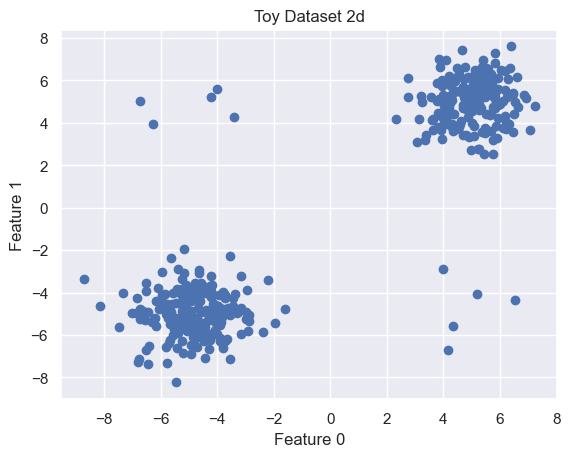

In [90]:
plt.scatter(X[:,0],X[:,2])
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('Toy Dataset 2d')
plt.savefig(os.getcwd()+'/toy_dataset_2d_scatter2.png')
plt.show()

In [91]:
X,y_3d=toy_dataset(3)
noise=np.random.normal(0,1,size=(X.shape[0],3))
X_toy_3d=np.column_stack((X,noise))
X_toy_3d.shape

(400, 6)

In [92]:
X,y_4d=toy_dataset(4)
noise=np.random.normal(0,1,size=(X.shape[0],2))
X_toy_4d=np.column_stack((X,noise))
X_toy_4d.shape

(400, 6)

In [93]:
X_toy_6d,y_6d=toy_dataset(6)
X_toy_6d.shape

(400, 6)

In [94]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data'

In [95]:
d={
    'X_toy_2d': X_toy_2d,
    'X_toy_3d': X_toy_3d,
    'X_toy_4d': X_toy_4d,
    'X_toy_6d': X_toy_6d,
    'y':y_2d,
}

file_to_read = os.getcwd()+'\\toy_datasets_an_dim_2.pkl'
with open(file_to_read, 'wb') as file:
    pickle.dump(d,file)

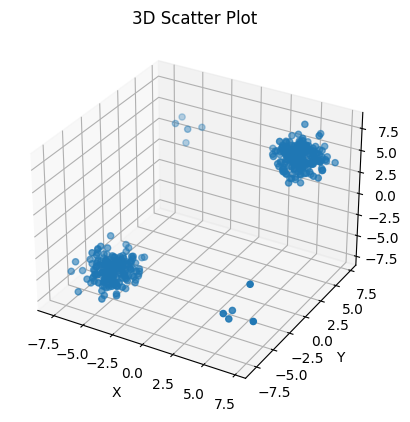

In [10]:
from mpl_toolkits.mplot3d import Axes3D
# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Create the scatter plot
ax.scatter(X[:,0],X[:,1],X[:,2])

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot')

# Show the plot
plt.show()